# Assignment:
In this Jupyter Notebook you find the answer to the asked question that follows:

<div style="border: 1px solid #ddd; border-radius: 5px; padding: 10px; background-color: #f9f9f9;">

With the data provided we would like to ask you to implement a ML classification model and provide the code necessary to train it from scratch. We are not asking for a model with any specific capabilities or performance, it is up to you to explore the problem and assess what could be reasonable and interesting within the given time constraints, taking design decisions accordingly. We'd like you to analyse the problem and give us some insights. The insights should be useful and actionable in some way.
    
We ask data scientist do want to join Idoven to work with anonymised patient data, and on the basis of this data be able to:

- Read the ECG files and corresponding annotations
- Show how they will work on the signal and plot the signal in appropriate manner to be read by a doctor
  
As a result we expect a github project with and extructure that will include:

- Reference documentation used
- **Jupyter Notebook** (this notebook), in an running environment, Colab, Docker.
- An explanation of the work done and lessons learned.

</div>
<br/><br/>

The structure of this Jupyter Notebook is as follow:
- **Exploratory Data Analysis (EDA)**: to understand the data and its properties (ECG files, signals, annotations, plots, data processing)
- **ML classification**: runnable script to train and evaluate the trained model. The code is provided as Jupyter Notebook which calls methods and modules from *.py* file to maintain verbosity on main actions
- **Conclusion**: discussion on the work done, lessons learned and possible future works. In this section a list of references is provided.  

In [1]:
data_path = '../data/ptbxl/'

## Exploratory Data Analysis (EDA)

#### Import libraries

In [2]:
import pandas as pd
import numpy as np
import os
import wfdb
import ast
import ecg_plot
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
## Defining functions as in example_physionet.py

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
    else:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
    data = np.array([signal for signal, meta in data])
    return data

In [4]:
# path = '/content/drive/MyDrive/ModelData/data/ptbxl/' -- get dataset from mounted drive account (relatively slow)
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(data_path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, data_path)


100%|██████████| 21837/21837 [00:52<00:00, 416.01it/s]


### Analyse CSVs


#### Annotation data
CSV file with patient's information, annotations and metadata

In [5]:
# Total number of rows and columns
print(f"Training Set:\nNumber of Rows: {Y.shape[0]}, Number of Columns: {Y.shape[1]}")
Y.head()

Training Set:
Number of Rows: 21837, Number of Columns: 27


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [6]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21837 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21837 non-null  float64
 1   age                           21748 non-null  float64
 2   sex                           21837 non-null  int64  
 3   height                        6983 non-null   float64
 4   weight                        9429 non-null   float64
 5   nurse                         20328 non-null  float64
 6   site                          21819 non-null  float64
 7   device                        21837 non-null  object 
 8   recording_date                21837 non-null  object 
 9   report                        21837 non-null  object 
 10  scp_codes                     21837 non-null  object 
 11  heart_axis                    13332 non-null  object 
 12  infarction_stadium1           5626 non-null   object 
 13  infarc

We have 27 columns with different data types. We can see that there are null values for several columns (we'll look at it later)


**Descriptive Analysis**

In [7]:
print("Dataset Descriptive Analysis for numerical values.")
Y.describe().transpose()

Dataset Descriptive Analysis for numerical values.


,count,mean,std,min,25%,50%,75%,max
patient_id,21837.0,11255.005953,6234.132489,302.0,5982.0,11423.0,16614.0,21797.0
age,21748.0,59.836307,16.953125,2.0,50.0,62.0,72.0,95.0
sex,21837.0,0.478912,0.499567,0.0,0.0,0.0,1.0,1.0
height,6983.0,166.708292,10.864935,6.0,160.0,166.0,174.0,209.0
weight,9429.0,70.997561,15.875146,5.0,60.0,70.0,80.0,250.0
nurse,20328.0,2.292503,3.254786,0.0,0.0,1.0,3.0,11.0
site,21819.0,1.547229,4.169753,0.0,0.0,1.0,2.0,50.0
validated_by,12426.0,0.747948,1.183269,0.0,0.0,1.0,1.0,11.0
strat_fold,21837.0,5.505335,2.875306,1.0,3.0,6.0,8.0,10.0


We can see that, as anticipated by the README.md in folder **data** male and female are almost the same percentage (balanced).\
The mean age is ~60 yo. with a std ~16, and the median value is 62yo.\
The height and weight have several missing values.

**Missing values**

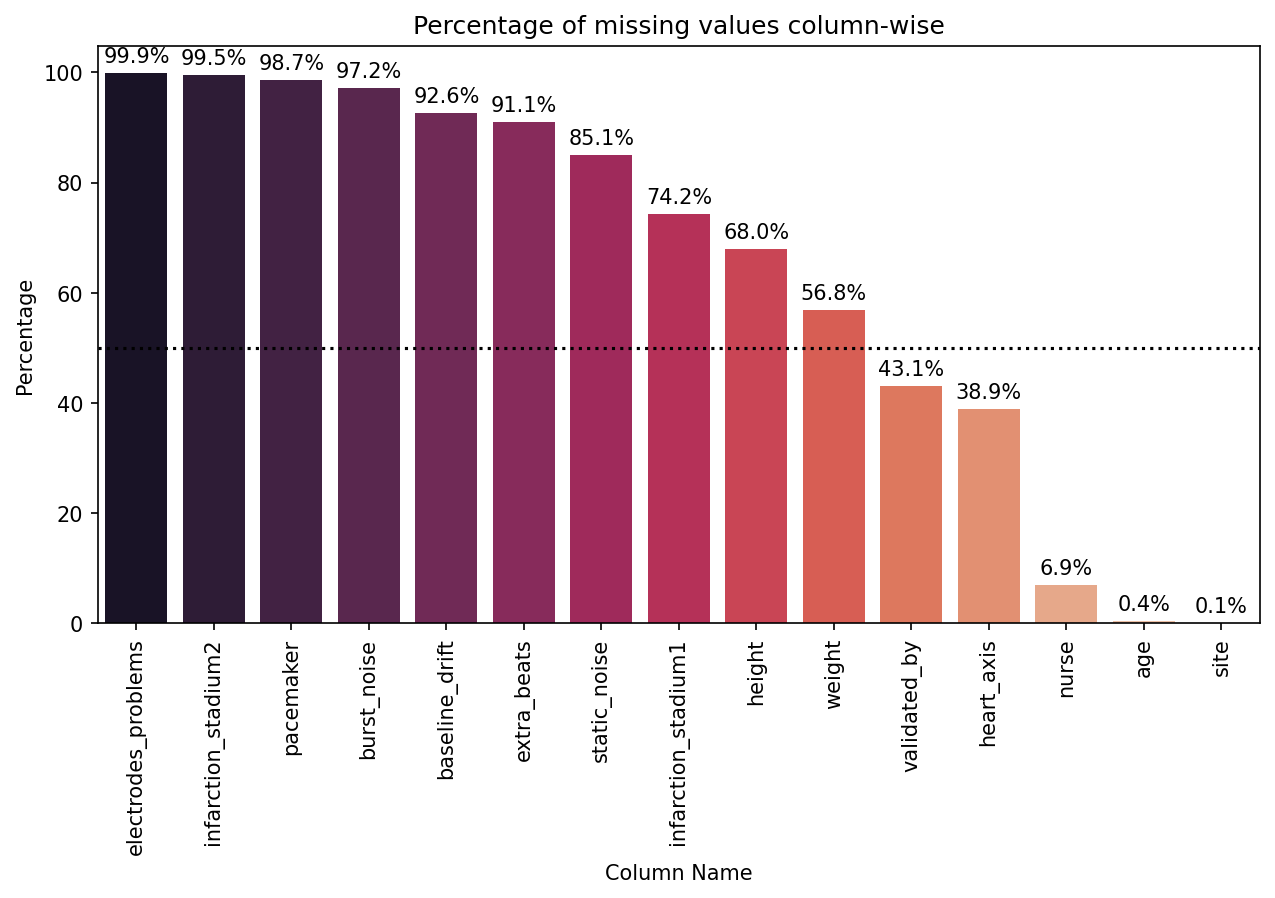

In [8]:
# Calculate percentage of missing values
null_values = Y.isnull().sum().sort_values(ascending=False)
percent = (Y.isnull().sum() / len(Y)) * 100
percent = percent[percent > 0].sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10,5 ), dpi=150)
ax = sns.barplot(x=percent.index, y=percent, palette="rocket")

# Add percentage values above the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 8), textcoords='offset points')

# Add horizontal dotted line at y=50
plt.axhline(50, color='black', linestyle='dotted')

# Set axis labels
plt.xlabel('Column Name')
plt.ylabel('Percentage')
plt.title('Percentage of missing values column-wise')
# Rotate x-axis labels
plt.xticks(rotation=90)

# Display the plot
plt.show()


**Correlations**

Pearson's correlation to check linear correletion among numerical variables.

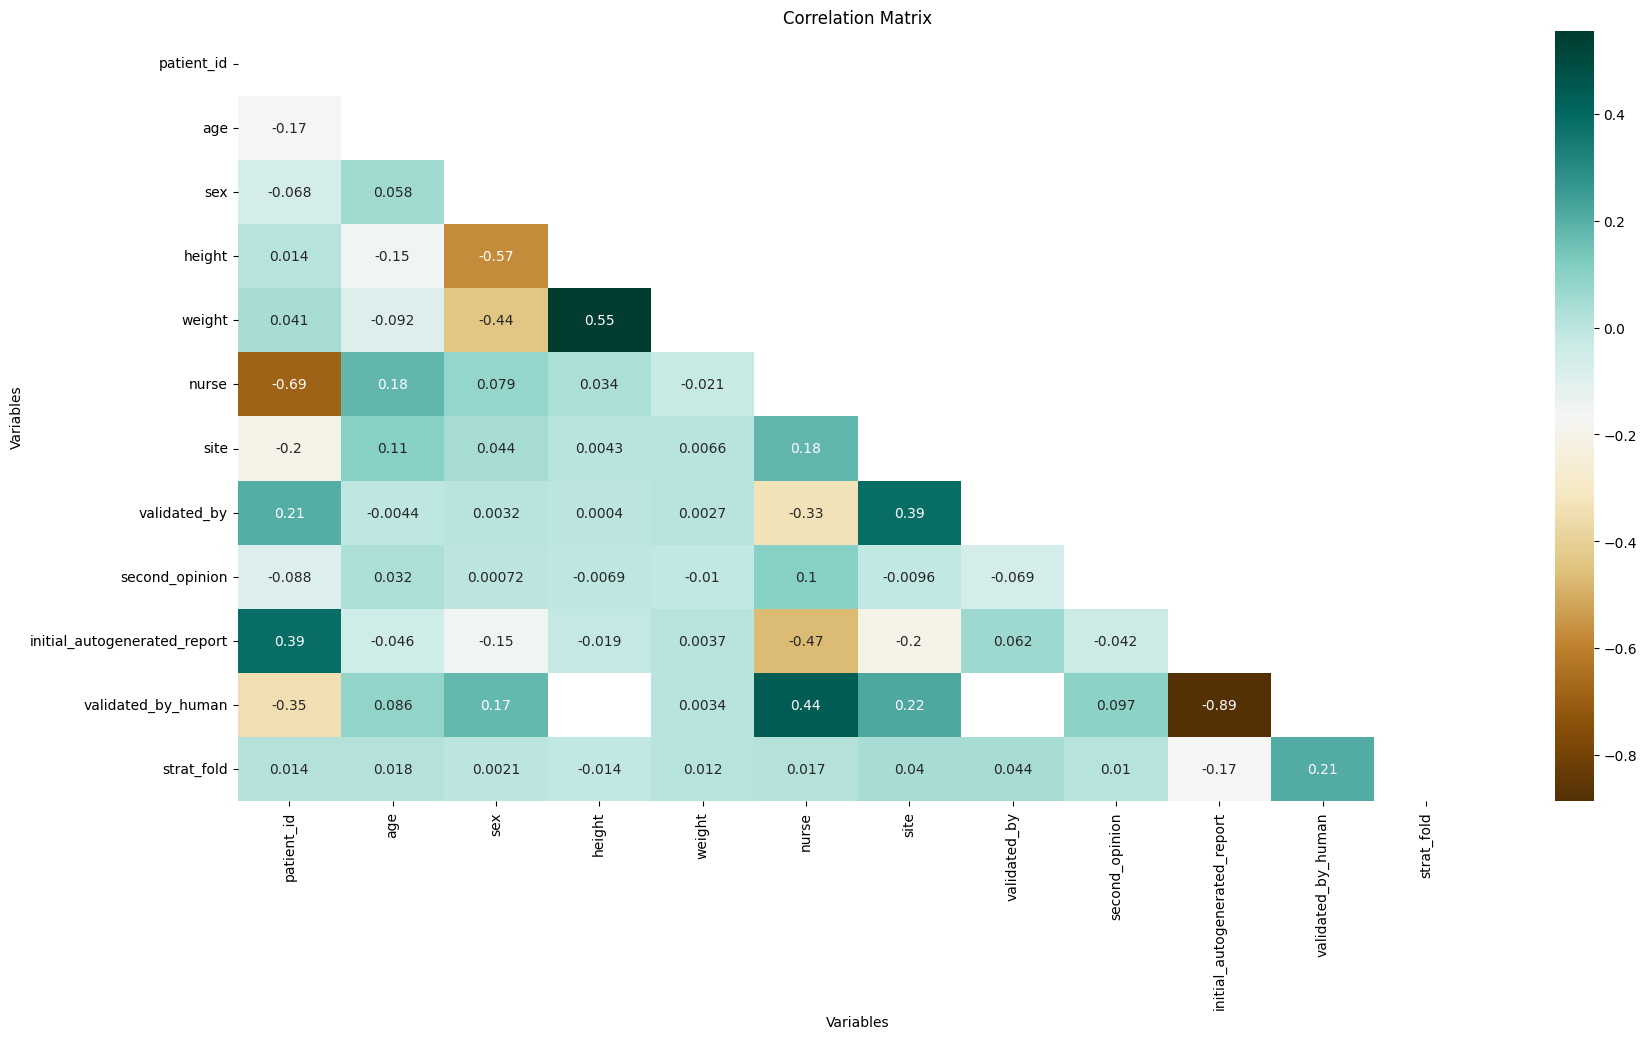

In [9]:
# Convert appropriate columns to numeric, using errors='coerce' to handle errors
Y_numeric = Y.apply(pd.to_numeric, errors='coerce')

# Drop columns that were fully converted to NaN due to non-numeric values
Y_numeric = Y_numeric.dropna(axis=1, how='all')

# Compute the correlation matrix
corr_matrix = Y_numeric.corr()

# Mask to only show upper triangle
mask = np.triu(corr_matrix)

# Plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, cmap="BrBG", annot=True, mask=mask)
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Correlation Matrix')
plt.show()

Considering the correlation of clinical metadata (such as *age, sex, weight* and *height*) we can see that height and weight are negative linearly correlated with *gender* variable (male are encoded as 0 and female as 1). This negative correlation between gender-height and gender-weigth suggests that males are, on average, taller and heavier than females. On the other hand, there is a positive linear correlation between height and weight that suggest that, on average, taller patients are also heavier.

#### Diagnostic Data
Load *scp_statements.csv*, explore the diagnostic values and perform aggregation.

In [10]:
# Load 
state_df = pd.read_csv(data_path+'scp_statements.csv', index_col=0)
print(f"Loaded dataset length: {len(state_df)}")
diag_df = state_df[state_df.diagnostic == 1] # keep value with diagnostic
print(f"Diagnosis in dataset: {len(diag_df)}")
diag_df.head()

Loaded dataset length: 71
Diagnosis in dataset: 44


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [11]:
print(f"{diag_df.diagnostic_class.nunique()} unique values for diagnostic_class: {(diag_df.diagnostic_class.unique())}")
print(f"{diag_df.diagnostic_subclass.nunique()} unique values for diagnostic_subclass: {(diag_df.diagnostic_subclass.unique())}")


5 unique values for diagnostic_class: ['STTC' 'NORM' 'MI' 'HYP' 'CD']
23 unique values for diagnostic_subclass: ['STTC' 'NST_' 'NORM' 'IMI' 'AMI' 'LVH' 'LAFB/LPFB' 'ISC_' 'IRBBB' '_AVB'
 'IVCD' 'ISCA' 'CRBBB' 'CLBBB' 'LAO/LAE' 'ISCI' 'LMI' 'RVH' 'RAO/RAE'
 'WPW' 'ILBBB' 'SEHYP' 'PMI']


We can see that there are the 5 *diagnostic_classes* as described in the problem statement, and 23 subclasses. Let's aggregate them in the annotation dataframe.

#### Aggregate diagnostic data with annotation data

Aggregate the information and then analyze the distribution onf variables wrt diagnosis.

**Diagnostic Superclass**

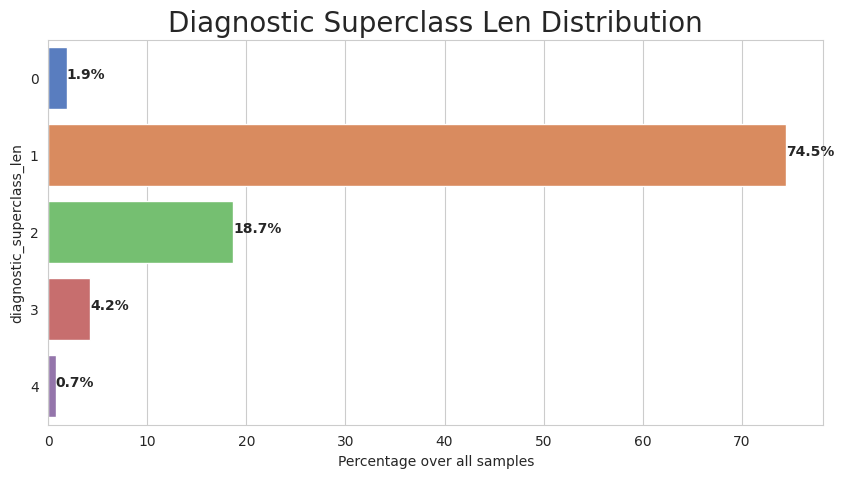

In [12]:
def aggregate_supclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in diag_df.index:
            tmp.append(diag_df.loc[key].diagnostic_class)
    return list(set(tmp))
    
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_supclass_diagnostic)
Y['diagnostic_superclass_len'] = Y['diagnostic_superclass'].apply(len)
Y.loc[Y.diagnostic_superclass_len > 1, 'diagnostic_superclass']

## Now plot the percentage len among sample

vc = Y['diagnostic_superclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnostic Superclass Len Distribution", fontsize=20)
ax.set_xlabel ("Percentage over all samples")
ax.set_ylabel ("diagnostic_superclass_len")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

**Diagnosti Subclass**

Do the same for subclasses

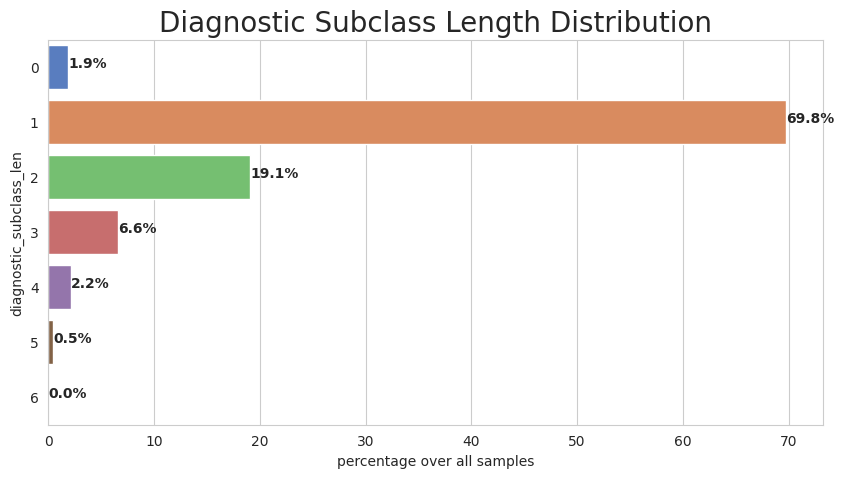

In [13]:
def aggregate_subclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in diag_df.index:
            tmp.append(diag_df.loc[key].diagnostic_subclass)
    ret = list(set(tmp))
    ret = ['sub_'+r for r in ret] # to distinguish between subclass and superclass columns
    return ret

# Apply diagnostic subclass
Y['diagnostic_subclass'] = Y.scp_codes.apply(aggregate_subclass_diagnostic)
Y['diagnostic_subclass_len'] = Y['diagnostic_subclass'].apply(len)
Y.loc[Y.diagnostic_subclass_len > 1, 'diagnostic_subclass']

vc = Y['diagnostic_subclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnostic Subclass Length Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnostic_subclass_len")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

#### Distribution analysis

In [14]:
## Functions
class ClassUpdate():
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, row):
        for sc in row['diagnostic_superclass']:
            row[sc] = 1
        for sc in row['diagnostic_subclass']:
            row[sc] = 1
            
        return row

def get_data_by_folds(folds, x, y, update_cols, feature_cols):
    assert len(folds)  > 0, '# of provided folds should longer than 1'
    #print(y.strat_fold)
    filt = np.isin(y.strat_fold.values, folds)
    x_selected = x[filt]
    y_selected = y[filt]
    
    for sc in update_cols:
        y_selected[sc] = 0
        
    cls_updt = ClassUpdate(update_cols)
    
    y_selected = y_selected.apply(cls_updt, axis=1)
    
    return x_selected, y_selected[list(feature_cols)+list(update_cols)+['strat_fold']]


In [15]:
all_superclass = pd.Series(np.concatenate(Y['diagnostic_superclass'].values))
superclass_cols = all_superclass.unique()
all_subclass = pd.Series(np.concatenate(Y['diagnostic_subclass'].values))
subclass_cols = all_subclass.unique()
update_cols = np.concatenate([superclass_cols, subclass_cols]) # concatenate subclass and superclass

meta_cols = ['age', 'sex', 'height', 'weight'] # add more columns as features


In [16]:
x_all, y_all = get_data_by_folds(np.arange(1, 11), X, Y, update_cols, meta_cols)
y_all.head()

,age,sex,height,weight,NORM,MI,STTC,HYP,CD,sub_NORM,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,56.0,1,NaN,63.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
2,19.0,0,NaN,70.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
3,37.0,1,NaN,69.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
4,24.0,0,NaN,82.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
5,19.0,1,NaN,70.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4


**Superclass distribution**

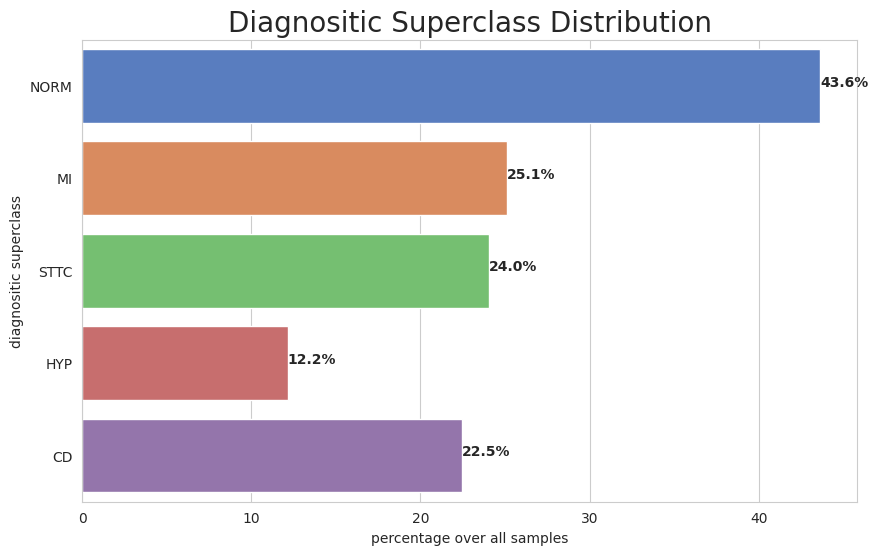

In [17]:
vc = y_all[superclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnositic Superclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic superclass")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

**Subclass distribution**

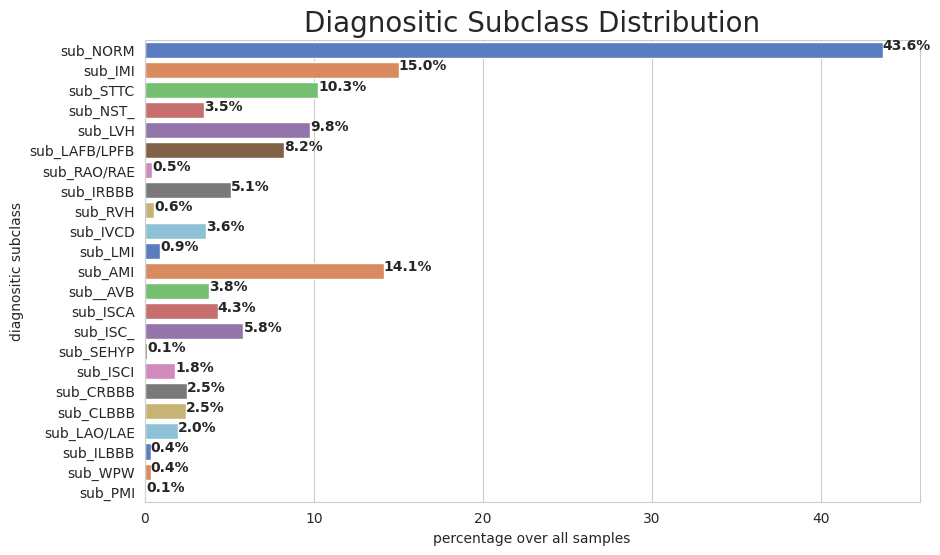

In [18]:
vc = y_all[subclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnositic Subclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic subclass")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
    

**Subclass distribution within superclass**

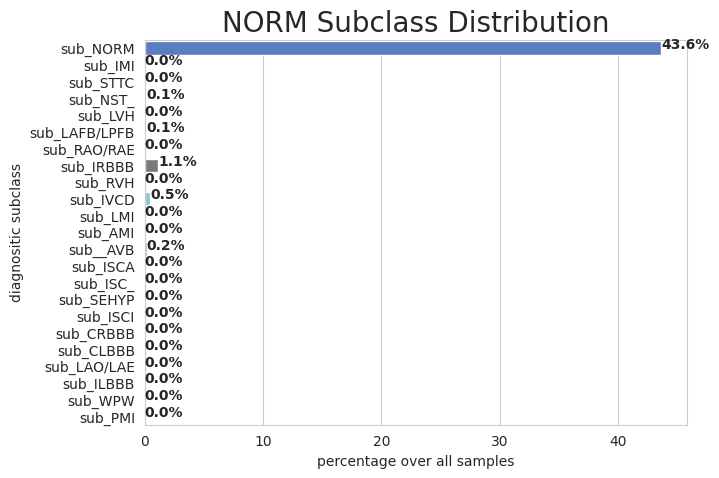

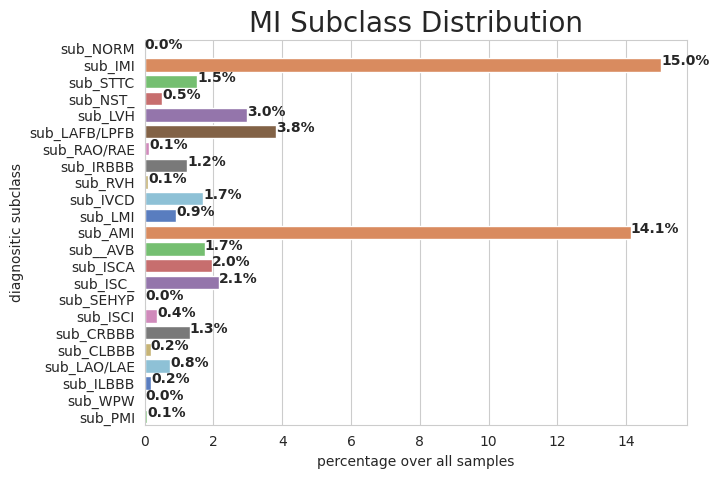

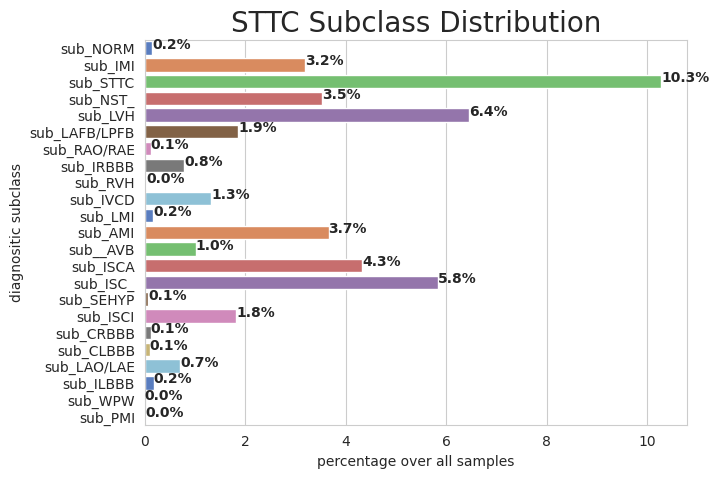

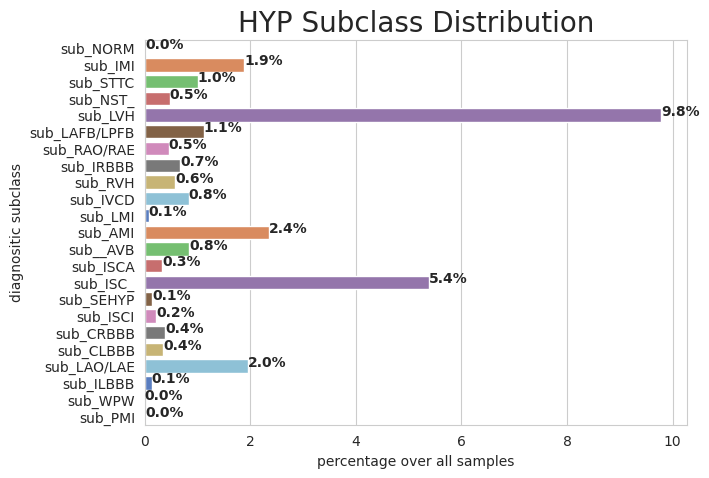

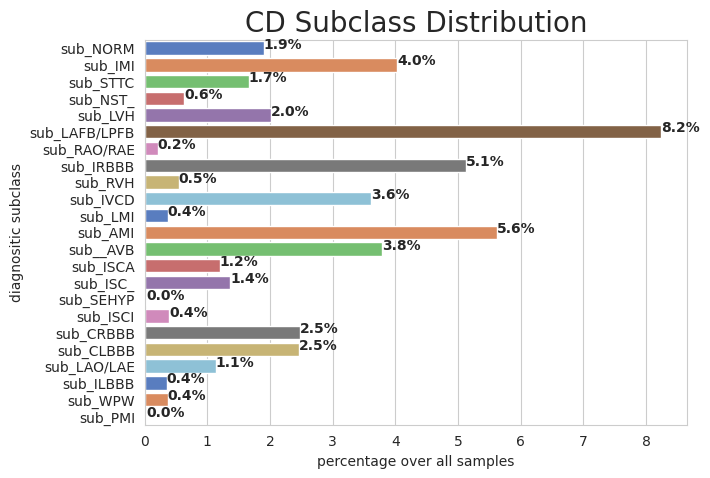

In [19]:
for superclass in superclass_cols:
    
    vc = y_all.loc[y_all[superclass] == 1][subclass_cols].sum(axis=0)
    
    sns.set_style("whitegrid")
    bar,ax = plt.subplots(figsize=(7,5))
    ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
    ax.set_title("{} Subclass Distribution".format(superclass), fontsize=20)
    ax.set_xlabel ("percentage over all samples")
    ax.set_ylabel ("diagnositic subclass")
    for rect in ax.patches:
        ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

**Vabiable distributions among superclasses**

 - **Numerical variables**

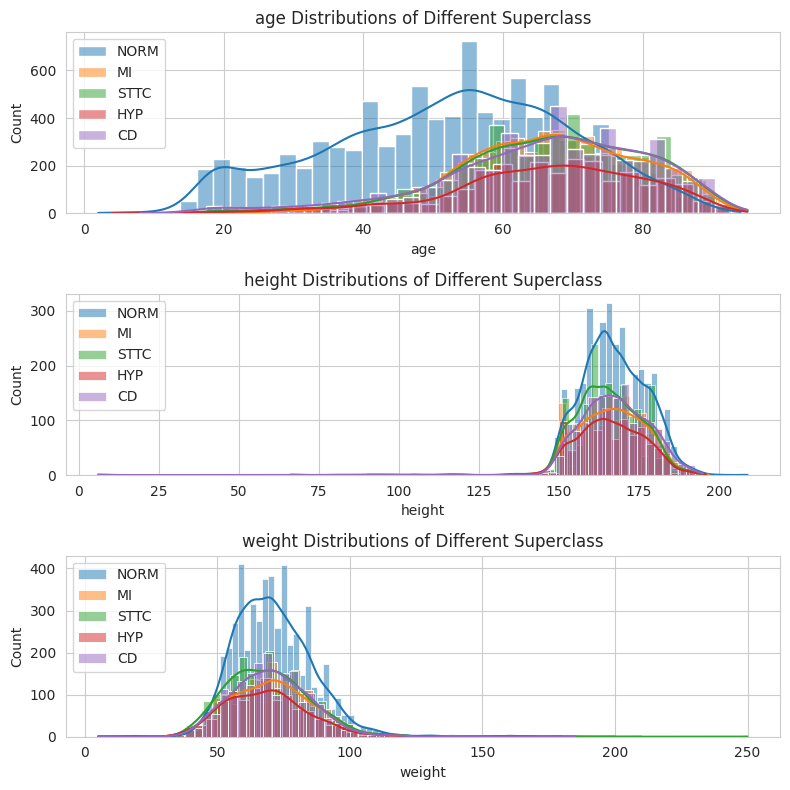

In [20]:
variables_to_plot = ['age', 'height', 'weight']
fig, axes = plt.subplots(len(variables_to_plot), 1, figsize=(8, 8))  # Adjust the figsize for better spacing

for i, variable in enumerate(variables_to_plot):
    axes[i].set_title(f'{variable} Distributions of Different Superclass')
    
    for superclass in superclass_cols:
        data = y_all.loc[y_all[superclass] == 1][variable]   
        sns.histplot(data, label=superclass, kde=True, ax=axes[i])
    
    axes[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

The weight and height distributions appear visually similar across different superclasses. However, the age distribution for the NORM superclass seems slightly left-skewed. To assess the statistical significance of these observations, we can perform statistical tests such as the Kolmogorov-Smirnov (KS) test or t-tests. Additionally, other appropriate tests include the Mann-Whitney U test for non-parametric data, ANOVA for comparing means across multiple groups, and the Chi-square test for categorical variables.

In [21]:
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu


# Remove rows with NaN values for the relevant variables
y_all_cleaned = y_all.dropna(subset=variables_to_plot + list(superclass_cols))

# Performing statistical tests
for variable in variables_to_plot:
    print(f'\nStatistical tests for {variable}:')

    superclass_pairs = [(superclass_cols[i], superclass_cols[j]) 
                        for i in range(len(superclass_cols)) 
                        for j in range(i + 1, len(superclass_cols))]
    
    for pair in superclass_pairs:
        data1 = y_all_cleaned.loc[y_all_cleaned[pair[0]] == 1][variable]
        data2 = y_all_cleaned.loc[y_all_cleaned[pair[1]] == 1][variable]
        
        ks_stat, ks_p_value = ks_2samp(data1, data2)
        ttest_stat, ttest_p_value = ttest_ind(data1, data2)
        mannwhitney_stat, mannwhitney_p_value = mannwhitneyu(data1, data2)
        
        print(f'{pair[0]} vs {pair[1]}:')
        print(f'  KS test: stat={ks_stat:.4f}, p-value={ks_p_value:.4e}')
        print(f'  t-test: stat={ttest_stat:.4f}, p-value={ttest_p_value:.4e}')
        print(f'  Mann-Whitney U test: stat={mannwhitney_stat:.4f}, p-value={mannwhitney_p_value:.4e}')



Statistical tests for age:
NORM vs MI:
  KS test: stat=0.4113, p-value=1.5091e-142
  t-test: stat=-30.9426, p-value=1.1141e-190
  Mann-Whitney U test: stat=946237.5000, p-value=7.4895e-186
NORM vs STTC:
  KS test: stat=0.3862, p-value=3.1863e-153
  t-test: stat=-31.6726, p-value=1.2402e-200
  Mann-Whitney U test: stat=1391398.5000, p-value=9.1662e-197
NORM vs HYP:
  KS test: stat=0.3991, p-value=5.2000e-108
  t-test: stat=-25.2872, p-value=2.6434e-131
  Mann-Whitney U test: stat=746018.0000, p-value=1.2644e-135
NORM vs CD:
  KS test: stat=0.3750, p-value=1.6104e-126
  t-test: stat=-27.0739, p-value=5.7842e-150
  Mann-Whitney U test: stat=1193861.5000, p-value=3.4318e-157
MI vs STTC:
  KS test: stat=0.0410, p-value=1.4610e-01
  t-test: stat=2.5424, p-value=1.1056e-02
  Mann-Whitney U test: stat=1245953.5000, p-value=9.2140e-02
MI vs HYP:
  KS test: stat=0.0342, p-value=5.0556e-01
  t-test: stat=1.6987, p-value=8.9510e-02
  Mann-Whitney U test: stat=671052.5000, p-value=5.0941e-01
MI vs

So, as noticed visually the NORM vs other classes for Age distributions resulted in:
- NORM vs MI:
  - Mann-Whitney U test: stat=946237.5000, p-value=7.4895e-186
- NORM vs STTC:
  - Mann-Whitney U test: stat=1391398.5000, p-value=9.1662e-197
- NORM vs HYP:
  - Mann-Whitney U test: stat=746018.0000, p-value=1.2644e-135
- NORM vs CD:
  - Mann-Whitney U test: stat=1193861.5000, p-value=3.4318e-157

all have a p-value < 0.005 which means that the differences between distribution has statistical significance and cannot be assessed only to randomness.

- **Categorical variables**

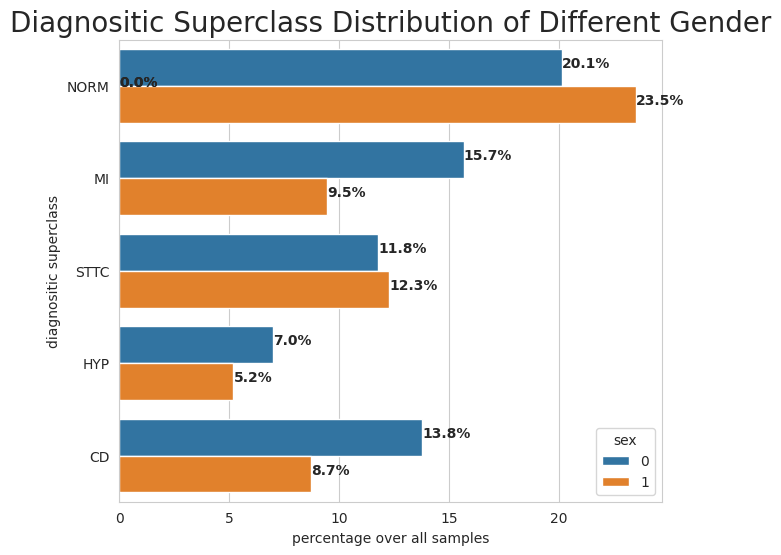

In [22]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(7,6))
    
ax.set_title("Diagnositic Superclass Distribution of Different Gender", fontsize=20)

all_index, all_count, all_values = [], [], []
for sex in y_all.sex.unique():
    vc = y_all.loc[y_all.sex == sex][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [sex]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['sex'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="sex",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold')

Again, here we can perform Chi-square test for categorical variables to asses the comparison among distributions. 

In [23]:
del X, Y
import gc
# Perform garbage collection
gc.collect()


38120

### Display ECG and pre-processing steps

To reduce verbosity and make it clear, in this section external function are used to load, aggregate and process data as explained in the previous subsections.

In [24]:
import riotis.core.dataloader as crloader
import riotis.core.eda.eda_plots as crplt
import riotis.core.eda.filters as crfilters


In [25]:
# Load the data
data_path = '../data/ptbxl/'
data = crloader.load_data(data_path= data_path,
                       sampling_rate=100)
print("\nData loaded.\n")


Data loaded.



**Access patient's data**: Display the ECG with diagnosis and metadata to be read by medical doctors. 

Patient 5678 has 1 ECGs.


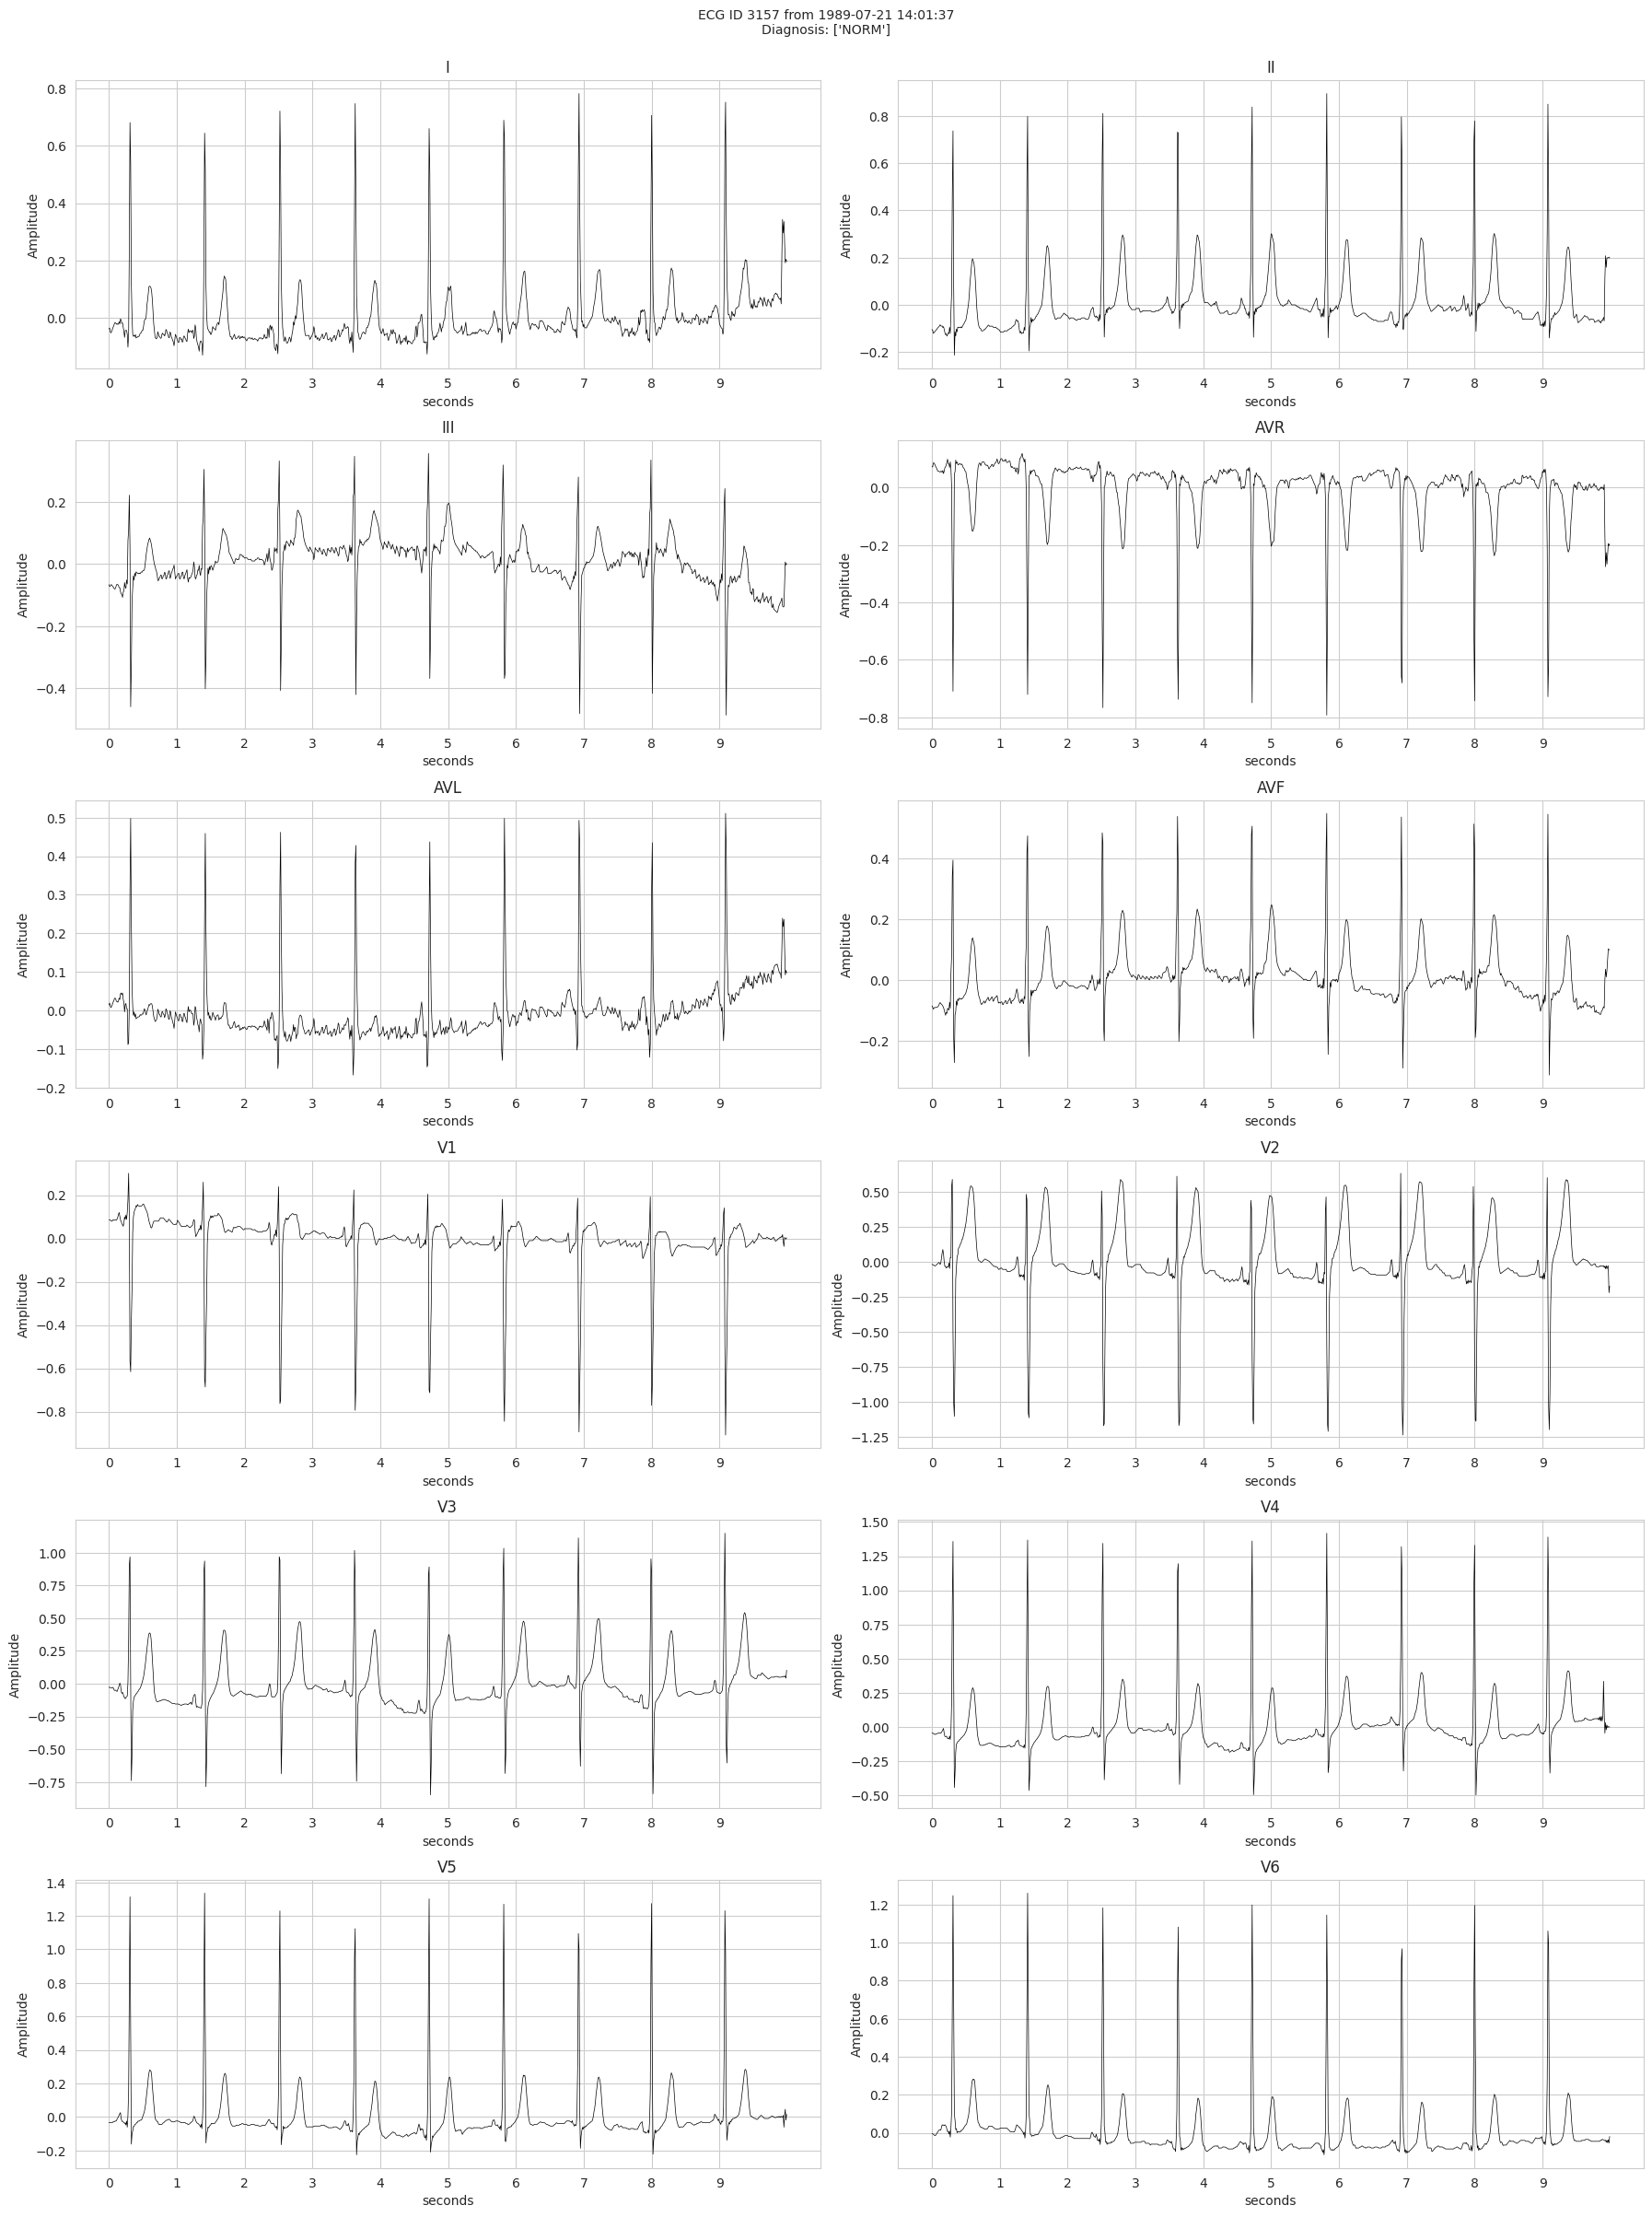

patient_id                                                                 5678.0
age                                                                          75.0
sex                                                                          male
height                                                                      183.0
weight                                                                       70.0
nurse                                                                         9.0
site                                                                          1.0
device                                                                 AT-6 C 5.3
recording_date                                                1989-07-21 14:01:37
report                          premature atrial contraction(s). sinus rhythm....
scp_codes                                   {'NORM': 80.0, 'PAC': 0.0, 'SR': 0.0}
heart_axis                                                                    NaN
infarction_stadi

In [26]:
# Access a specific patient's data
patient_id = 5678
ecg_ids = crloader.get_patient_id_ecg_ids(patient_id=patient_id,
                                          annotations=data['train']['annotations'])

print(f"Patient {patient_id} has {len(ecg_ids)} ECGs.")
ecg_id, ecg_date = ecg_ids[-1]  # most recent

signals = crloader.get_signal_from_ecg_id(ecg_id=ecg_id,
                                          raw_data=data['train']['data'],
                                          channel=-1)

annots = crloader.get_annotations_from_ecg_id(ecg_id=ecg_id,
                                              annotations=data['train']['annotations'])

# Visualize the ECG signal for all channels and annotations
data_display = crplt.plot_ecg_channels(raw_data=data['train']['data'][ecg_id],
                                       title=f"ECG ID {ecg_id} from {ecg_date}\nDiagnosis: {data['train']['annotations']['diagnostic_superclass'][ecg_id]}")

# Display annotations
annots

#### Signal preprocessing steps

By preprocessing the signals, one can make them smoother, remove outliers, etc.

##### Filtering

A common pre-process when working with signals is smoothing/filtering. That allows to remove some outliers and noise from the signal for a better analysis.

Some of the most used signal filtering techniques are:
- Savitzky-Golay filter
- Gaussian filter
- Median filter
- Low-pass filter
- High-pass filter
- Butterworth filter (band-pass filter)
- Convolution filter

The biggest challenge of filtering is the manual tunning. Finding the right parameters is a empirical work.

Below, some filters applied to the same signal.

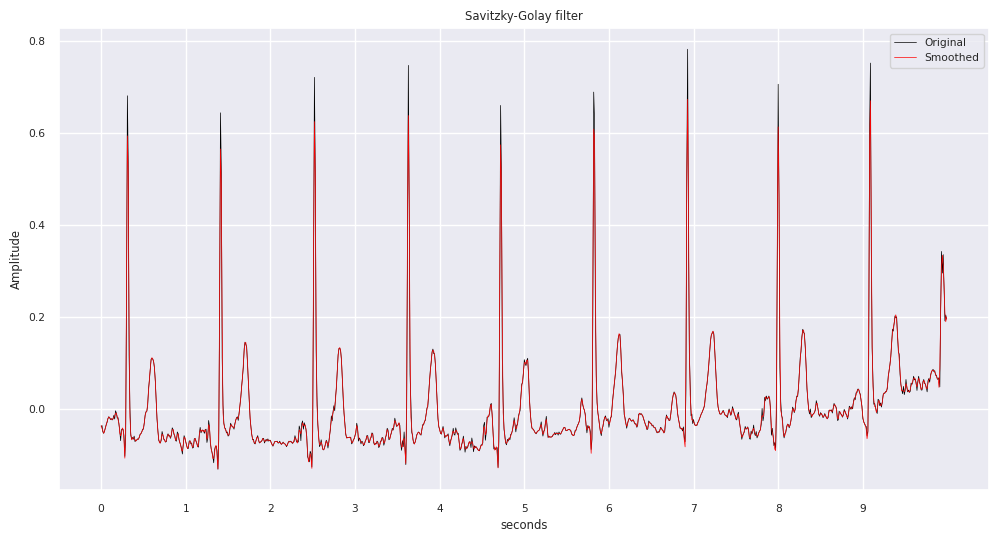

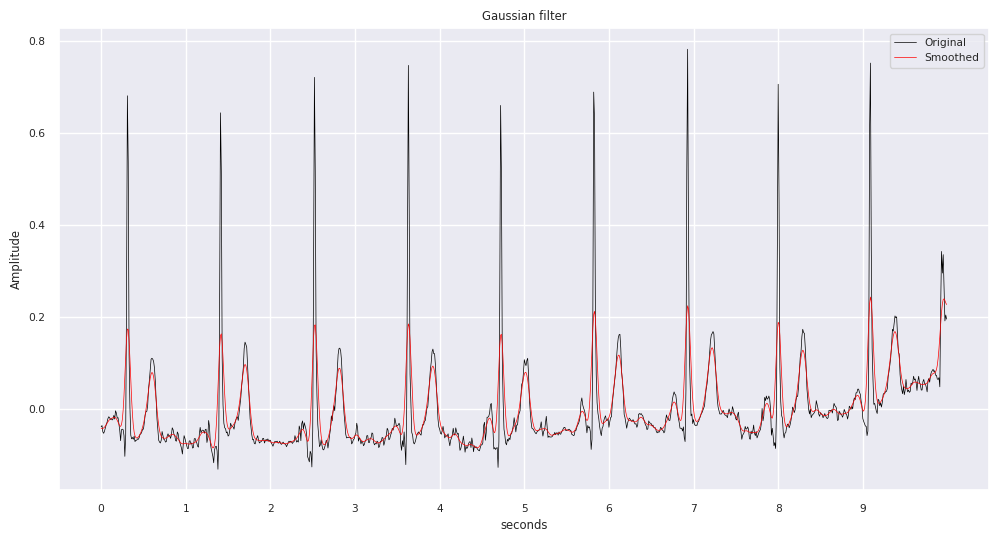

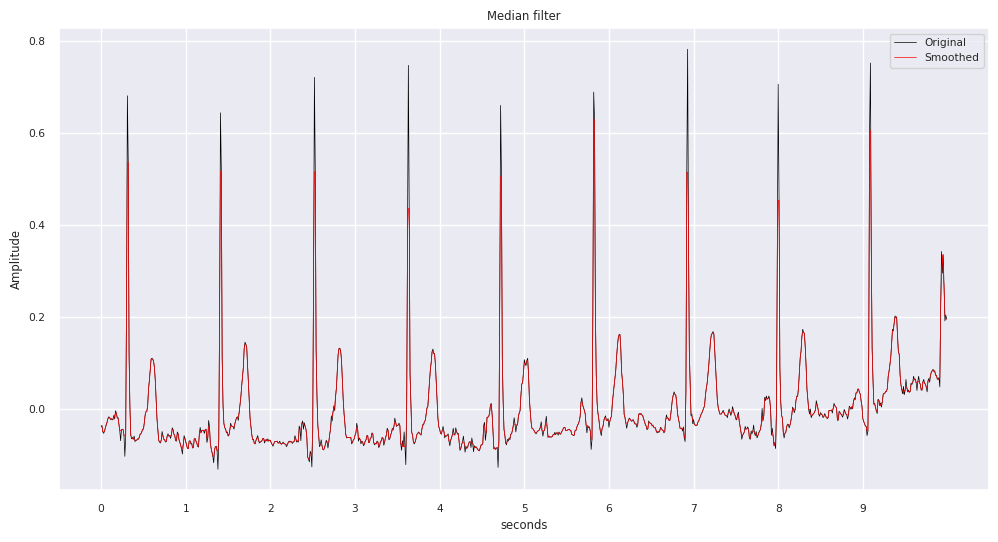

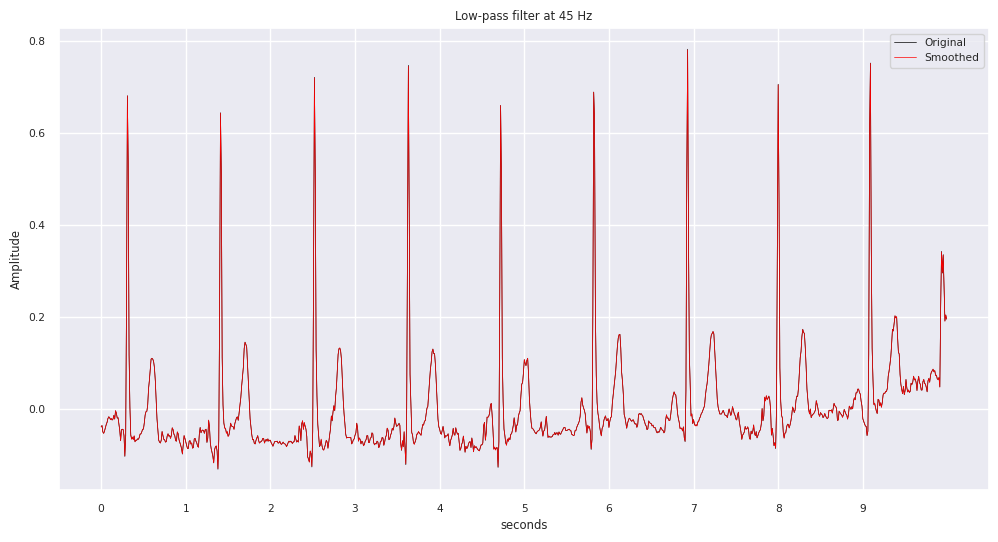

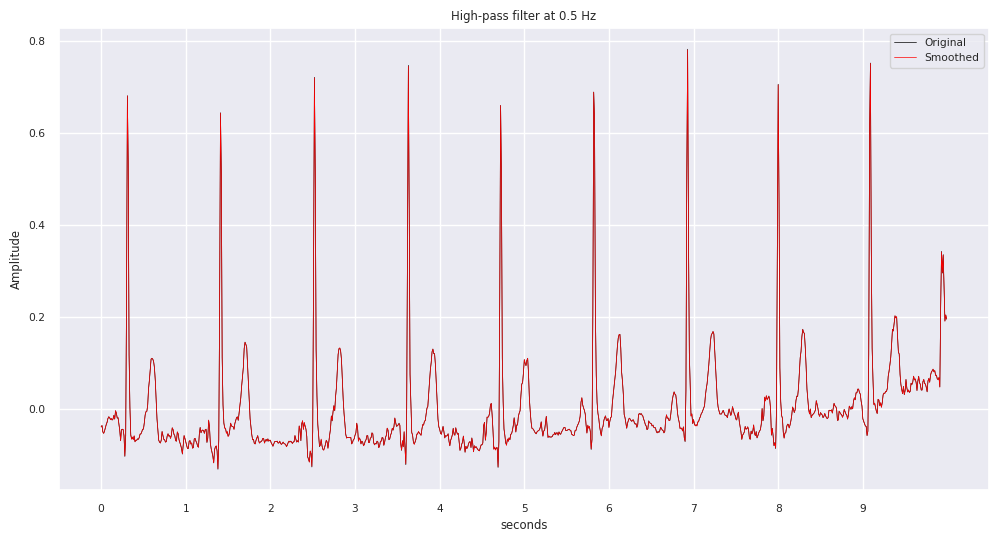

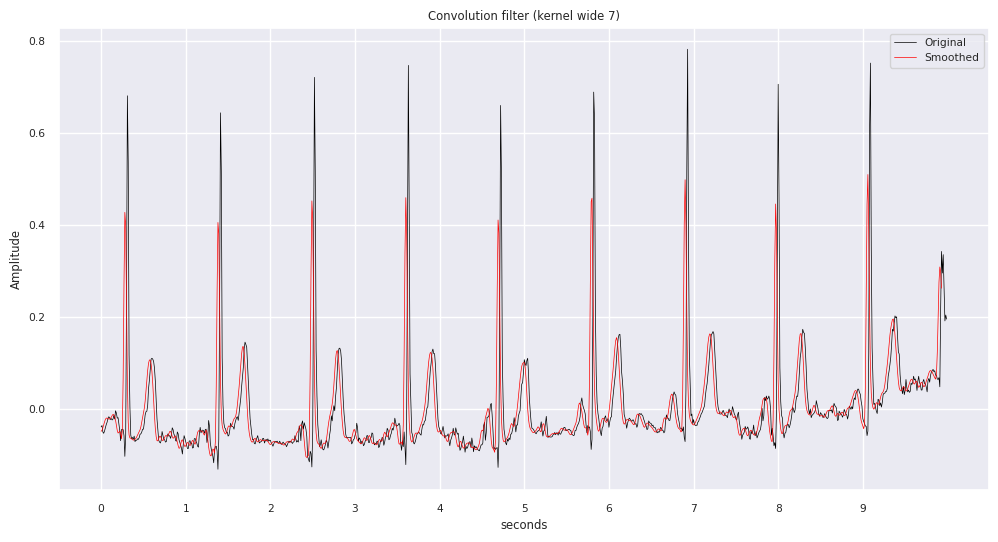

In [27]:
channel = 0
original_signal = signals[:, channel]

# Savitzky-Golay filter
savgol_ecg = crfilters.smooth_signal_savgol(ecg_signal=original_signal,
                                        window_length=5,
                                        polyorder = 2)
crplt.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=savgol_ecg,
                           title="Savitzky-Golay filter")
# Gaussian filter
gaussian_ecg = crfilters.smooth_signal_gaussian(ecg_signal=original_signal, sigma=3)
crplt.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=gaussian_ecg,
                           title="Gaussian filter")
# Median filter
median_ecg = crfilters.smooth_signal_median(ecg_signal=original_signal, kernel_size=3)
crplt.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=median_ecg,
                           title="Median filter")

# Low-pass filter
lowcut = 45
lowpass_ecg = crfilters.smooth_signal_lowpass(ecg_signal=original_signal,
                                          sample_rate=100,
                                          order_filter=5,
                                          cut=lowcut)
crplt.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=lowpass_ecg,
                           title=f"Low-pass filter at {lowcut} Hz")

# High-pass filter
highcut = 0.5
highpass_ecg = crfilters.smooth_signal_highpass(ecg_signal=original_signal,
                                          sample_rate=100,
                                          order_filter=5,
                                          cut=highcut)
crplt.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=lowpass_ecg,
                           title=f"High-pass filter at {highcut} Hz")

# Convolution filter
kernel = 7
conv_ecg = crfilters.smooth_signal_convolution(ecg_signal=original_signal,
                                           kernel=kernel)
crplt.plot_filtered_signal(ecg_signal=original_signal,
                           smoothed_ecg=conv_ecg,
                           title=f"Convolution filter (kernel wide {kernel})")

An example of manual tuining can be: see the influence of difference frequency cuts on a low-filter.

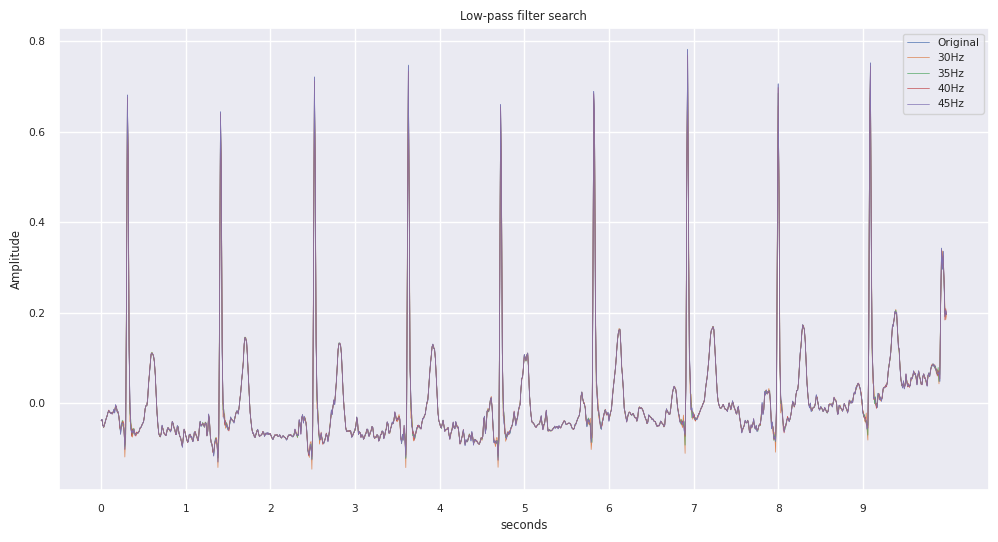

In [28]:
lowpass_ecgs = []
cutoffs = []
for lowcut in range(30, 50, 5):
    lowpass_ecg = crfilters.smooth_signal_lowpass(ecg_signal=original_signal,
                                            sample_rate=100,
                                            order_filter=5,
                                            cut=lowcut)
    lowpass_ecgs.append(lowpass_ecg)
    cutoffs.append(f"{lowcut}Hz")

crplt.plot_filtered_signals(ecg_signal=original_signal,
                           smoothed_ecgs=lowpass_ecgs,
                           labels=cutoffs,
                           title="Low-pass filter search")

Filtering is commonly used to eliminate baseline wander, a common artifact that distorts ECG signals. This artifact can arise from various noise sources, such as respiration, body movements, and poor electrode contact, and typically affects frequencies below 0.5 Hz.

However, most baseline wander removal methods can alter the ECG signal, potentially compromising its clinical significance, making the process challenging.

A simple baseline wander estimator was implemented using a sequence of median filters with varying kernel sizes. The kernel size is determined based on the sampling rate and the desired window duration in seconds.

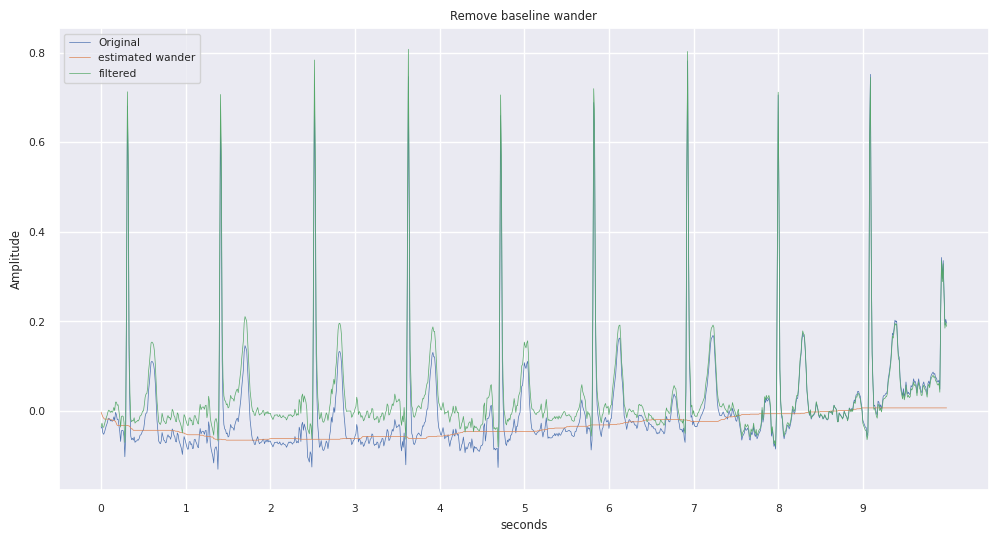

In [29]:
wander = crfilters.estimate_baseline_wander(ecg_signal=original_signal,durations=[0.5, 2], sample_rate=100)
rem_wander_ecg = crfilters.remove_baseline_wander(ecg_signal=original_signal,durations=[0.5, 2], sample_rate=100)

crplt.plot_filtered_signals(ecg_signal=original_signal,
                           smoothed_ecgs=[wander, rem_wander_ecg],
                           labels=['estimated wander', 'filtered'],
                           title="Remove baseline wander")

Once we have the ECG signal, there are several basic analyses that can be performed. One of the most important aspects of an ECG is the [QRS complex](https://en.wikipedia.org/wiki/QRS_complex)., which provides key information about the heart's electrical activity.

In simple terms:

- R peaks are the highest points in the ECG waveform.
- Q peaks are the lowest points before the R peak.
- S peaks are the lowest points after the R peak.
  
The R peaks can be used to estimate the heart rate.

Some commonly used algorithms for detecting the QRS complex include:

- Pan and Tompkins
- Hamilton
- Christov
- Stationary Wavelet Transform
- Two Moving Average
  
You can find an implementation of these detectors [here](https://github.com/berndporr/py-ecg-detectors). However, after testing it, in many cases, the R peak detection was inaccurate. So, an alternative implementation of  [Pan and Tompkins QRS complex detector](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm) has been used and imported in this project.


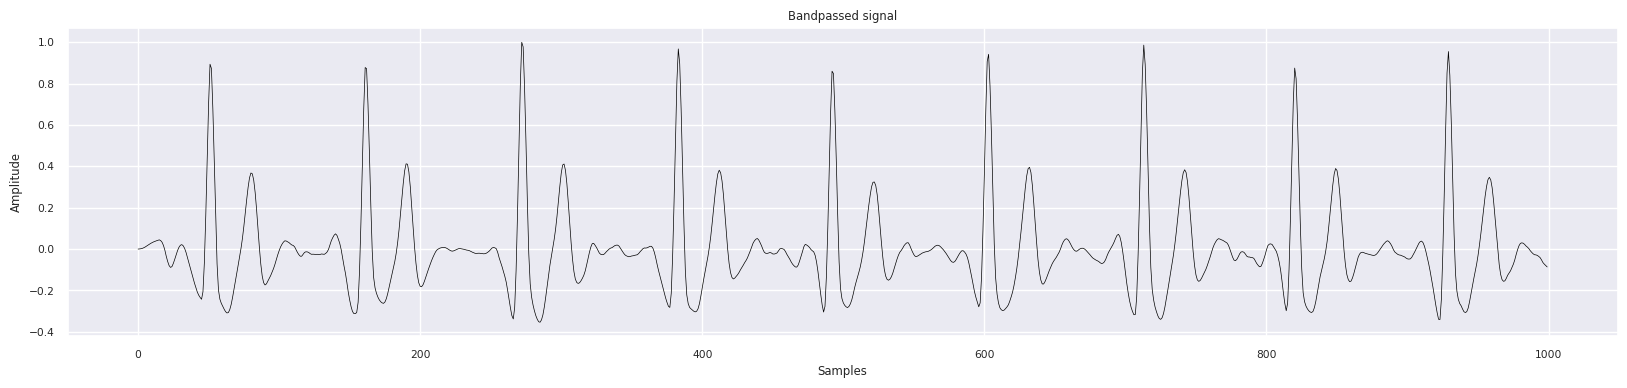

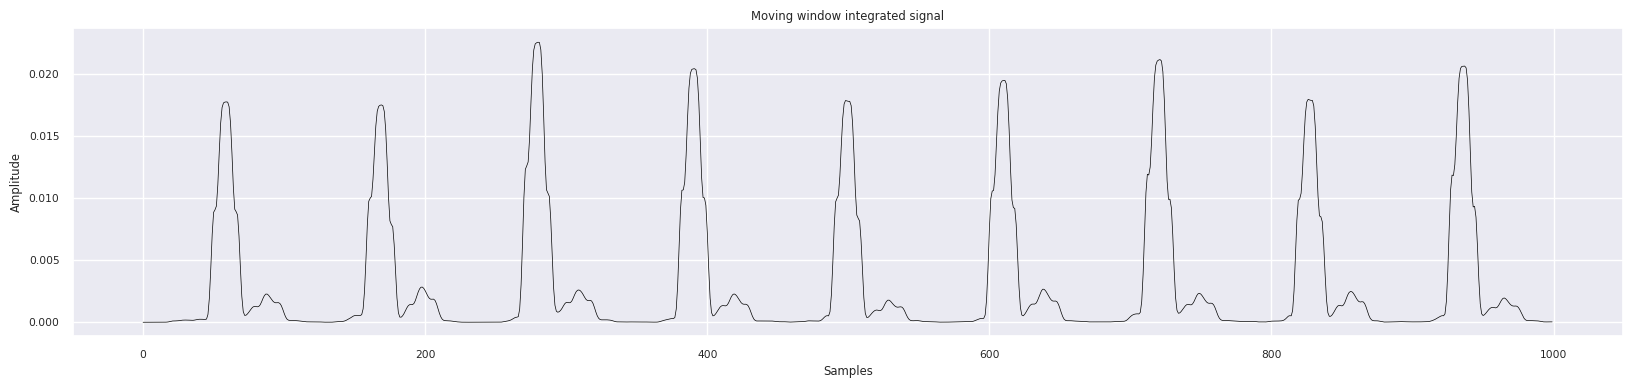

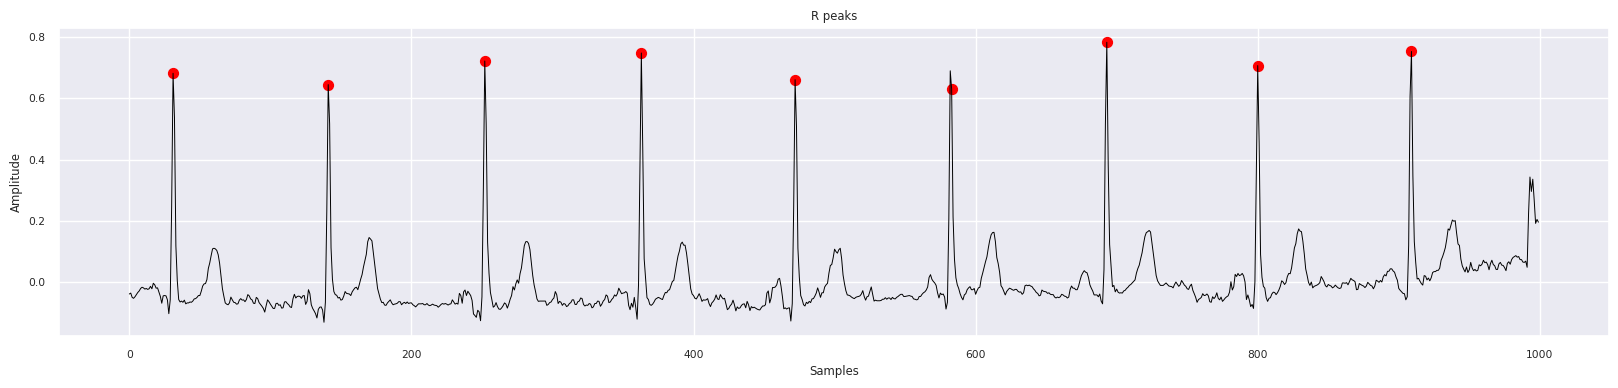

Heart rate: 54.69 +- 0.26 bpm


In [30]:
from riotis.core.eda.pan_tompkins import PanTompkinsQRS
peak_detector = PanTompkinsQRS(signal=original_signal, sample_rate=100, window_size=0.15)

crplt.plot_signal(signal=peak_detector.band_pass_sgn,
                  xlabel="Samples",
                  ylabel="Amplitude",
                  title="Bandpassed signal")

crplt.plot_signal(signal=peak_detector.mov_win_sgn,
                  xlabel="Samples",
                  ylabel="Amplitude",
                  title="Moving window integrated signal")

peak_detector.find_r_peaks()

crplt.plot_signal_and_rpeaks(signal=original_signal,
                             rpeaks_loc=peak_detector.tuned_peaks,
                             xlabel="Samples",
                             ylabel="Amplitude",
                             title="R peaks")

heart_bpm, heart_var = peak_detector.estimate_heartrate()
print(f"Heart rate: {heart_bpm:.2f} +- {heart_var:.2f} bpm")

#### EDA of train/validation/test splits

Look for possible biases among the splits before training the model.

Use the splits as suggested:


<div style="border: 1px solid #ddd; border-radius: 5px; padding: 10px; background-color: #f9f9f9;">

Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

</div>


Number of classes: 5


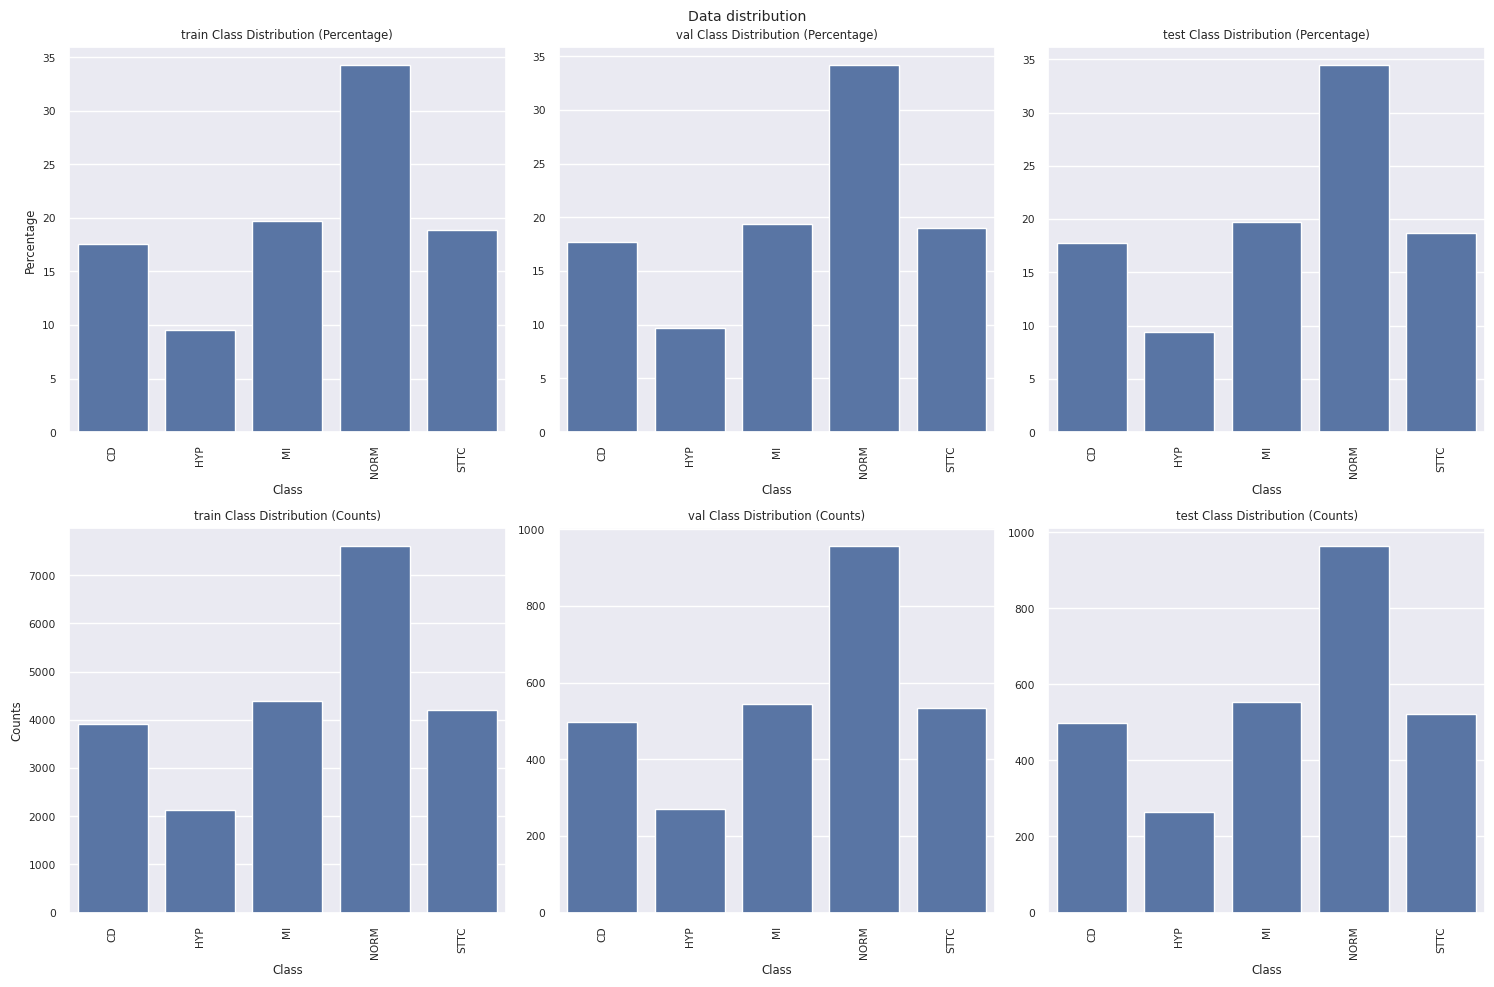

Number of classes: 22


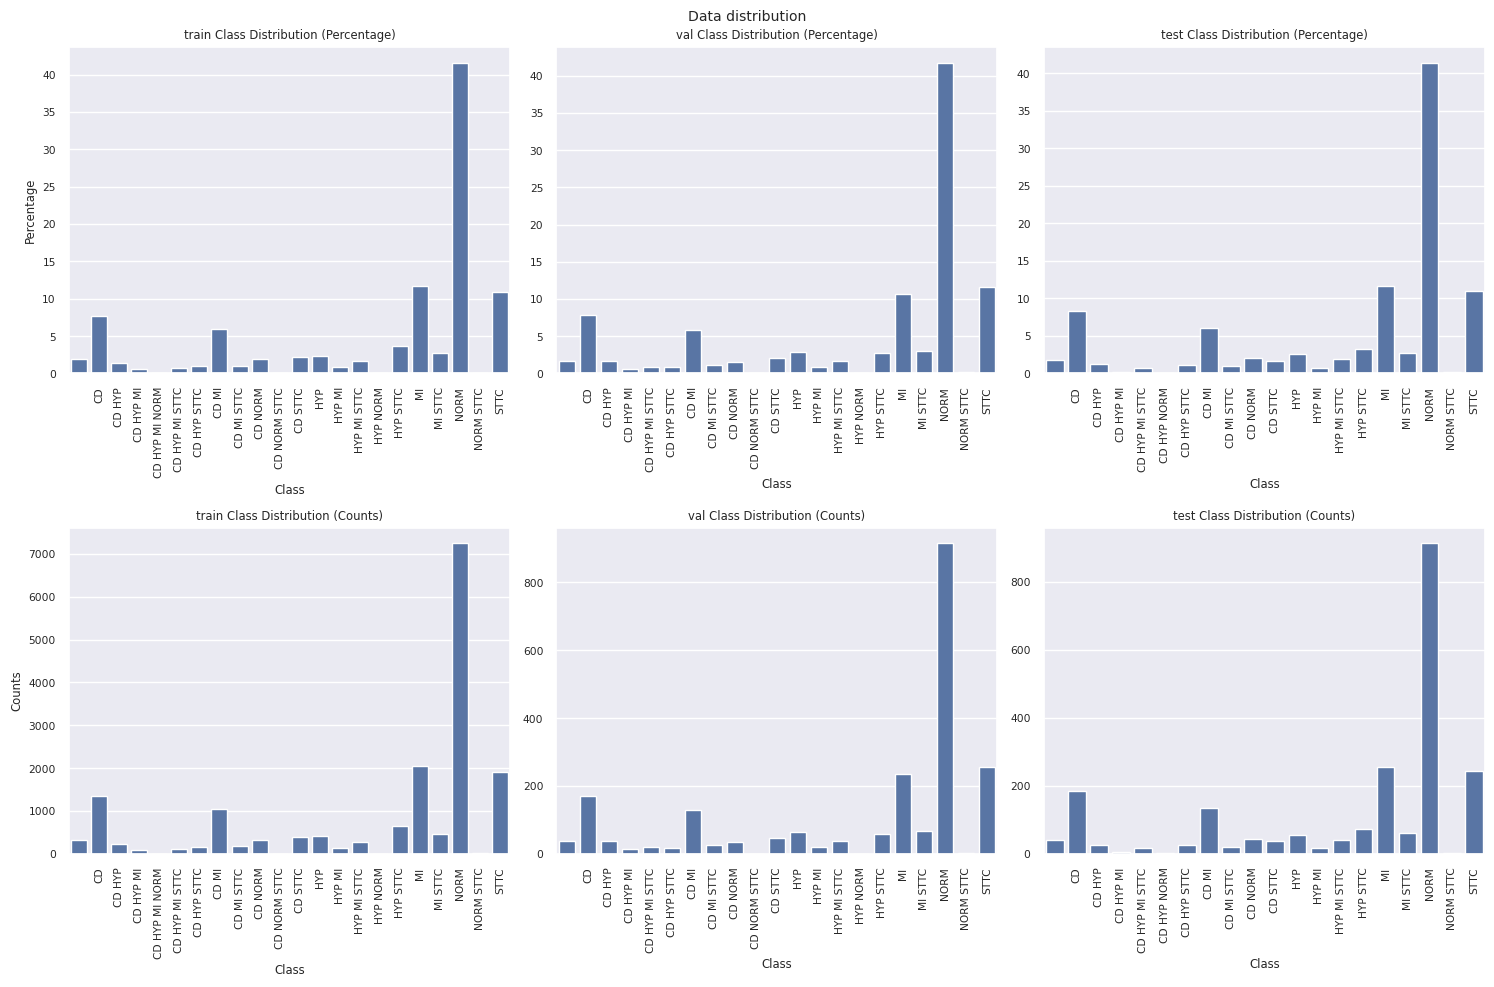

In [31]:
from riotis.core.utils import calculate_distribution

datasets = ["train", "val", "test"]
class_counts = {}
class_percentages = {}

for dataset in datasets:
    class_counts[dataset], class_percentages[dataset] = calculate_distribution(data[dataset]["labels"],
                                                                                       use_combo=False)

num_classes = len(class_counts["train"])
print(f"Number of classes: {num_classes}")

crplt.plot_data_distribution(class_counts, class_percentages)

datasets = ["train", "val", "test"]
class_counts = {}
class_percentages = {}

for dataset in datasets:
    class_counts[dataset], class_percentages[dataset] = calculate_distribution(data[dataset]["labels"],
                                                                                       use_combo=True)

num_classes = len(class_counts["train"])
print(f"Number of classes: {num_classes}")

crplt.plot_data_distribution(class_counts, class_percentages)

In [32]:
for ds_type in datasets:
    single_label = 0
    norm_label = 0
    multi_label = 0
    for key, perc in class_percentages[ds_type].items():
        if " " in key:
            multi_label += perc
        else:
            single_label += perc
            if "norm" == key.lower():
                norm_label += perc
    print(f"Dataset type: {ds_type}")
    print(f"\tPercentage of single labels: {single_label:.2f}%")
    print(f"\t\tNORM contribution: {norm_label:.2f}%")
    print(f"\t\tNon NORM contribution: {single_label - norm_label:.2f}%")
    print(f"\tPercentage of multi labels: {multi_label:.2f}%")

Dataset type: train
	Percentage of single labels: 76.30%
		NORM contribution: 41.59%
		Non NORM contribution: 34.71%
	Percentage of multi labels: 23.70%
Dataset type: val
	Percentage of single labels: 76.56%
		NORM contribution: 41.77%
		Non NORM contribution: 34.79%
	Percentage of multi labels: 23.44%
Dataset type: test
	Percentage of single labels: 76.80%
		NORM contribution: 41.44%
		Non NORM contribution: 35.36%
	Percentage of multi labels: 23.20%


We observe that there are 5 unique labels and 22 out of the 31 possible label combinations.

A few additional points to note:

- Some data points lack a class label.
- The data is balanced across different splits.
- Single labels dominate the dataset.
- The label "NORM" alone accounts for approximately 40% of the data in each split.
- The data does not exhibit a long-tail distribution (when ignoring label combinations).

Given that this is a health-related use case, factors like sex and age are often critical. Let's verify if this data is also well-distributed.

In [33]:
from collections import Counter
for ds_type in datasets:
    sex_count = Counter(data[ds_type]["annotations"].sex)
    total = sum(sex_count.values())
    print(f"Dataset type: {ds_type}")
    print(f"\tMale percentage: {sex_count['male']/total:.2%} ({sex_count['male']})")
    print(f"\tFemale percentage: {sex_count['female']/total:.2%} ({sex_count['female']})")

Dataset type: train
	Male percentage: 52.20% (9104)
	Female percentage: 47.80% (8337)
Dataset type: val
	Male percentage: 52.16% (10242)
	Female percentage: 47.84% (9392)
Dataset type: test
	Male percentage: 52.11% (11379)
	Female percentage: 47.89% (10458)


Although there is a slightly prevalence of `male`, the `sex` attribute is properly distributed between splits as in the original dataset.

Let's analyze the `age` distribution per `sex`.

Dataset type: train


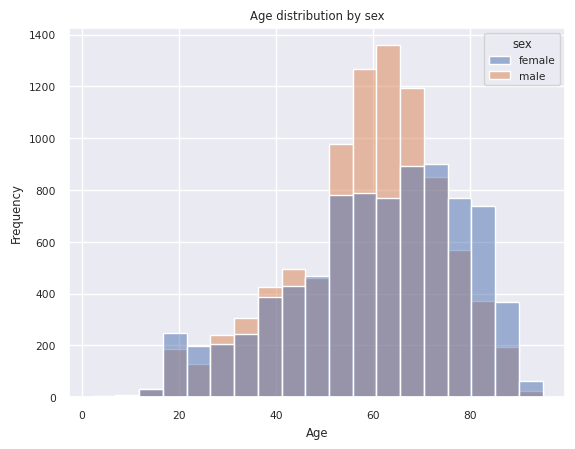

Dataset type: val


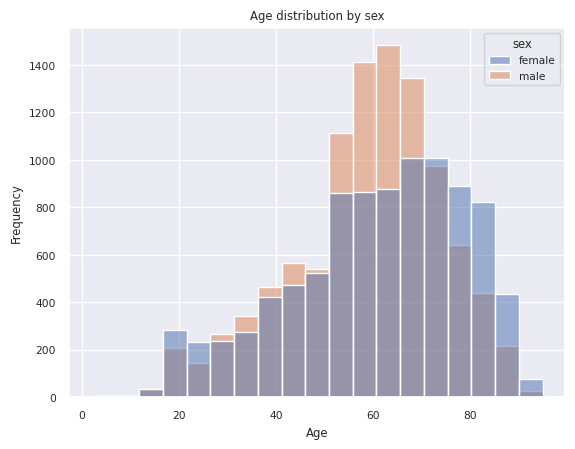

Dataset type: test


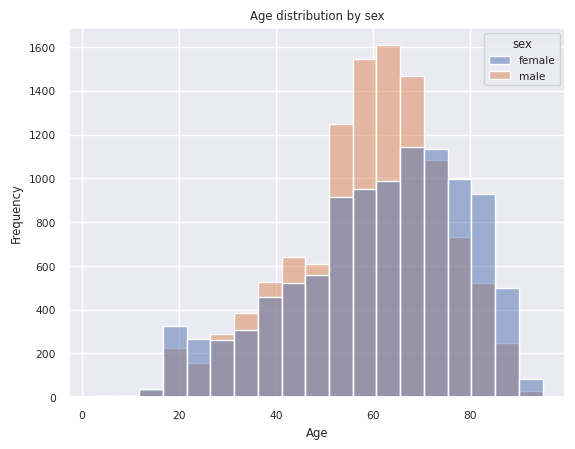

In [34]:
for ds_type in datasets:
    print(f"Dataset type: {ds_type}")
    crplt.plot_distribution_age_sex(data[ds_type]["annotations"])

`age` and `sex` distribution is very similar among splits. We have more `female` data in the extremes and more `male` data in the centre

This last points alert us to check for bias in the results later on.

Finally, lets check the `diagnostic` distribution per `sex`.

Dataset type: train


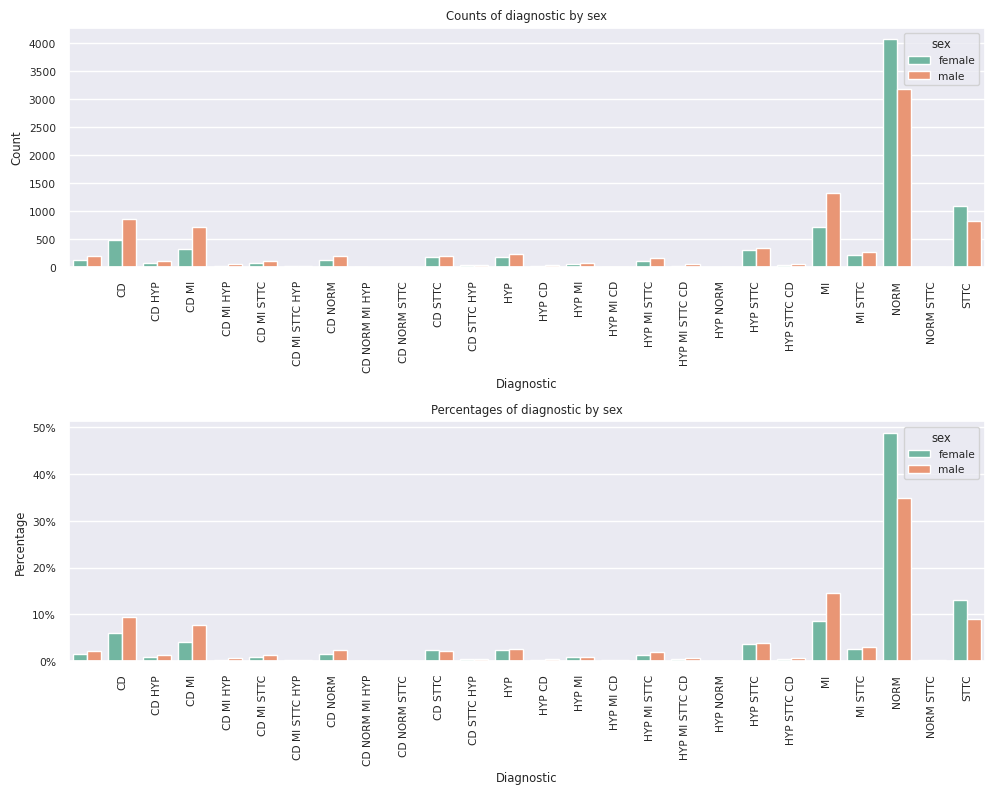

Dataset type: val


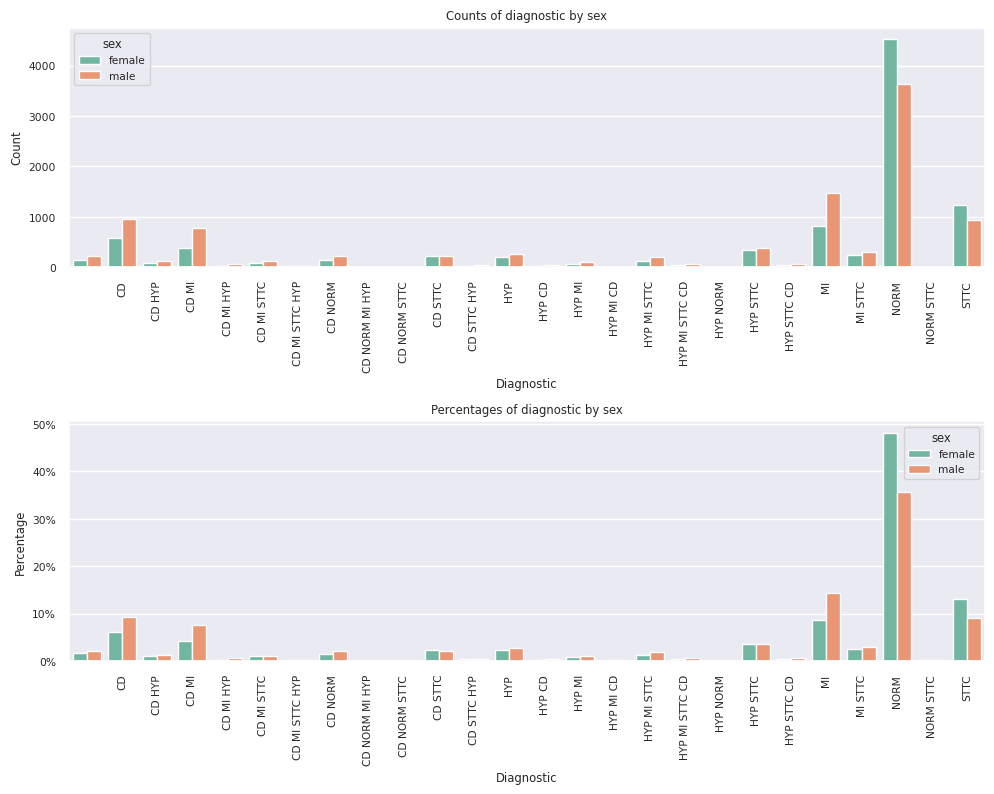

Dataset type: test


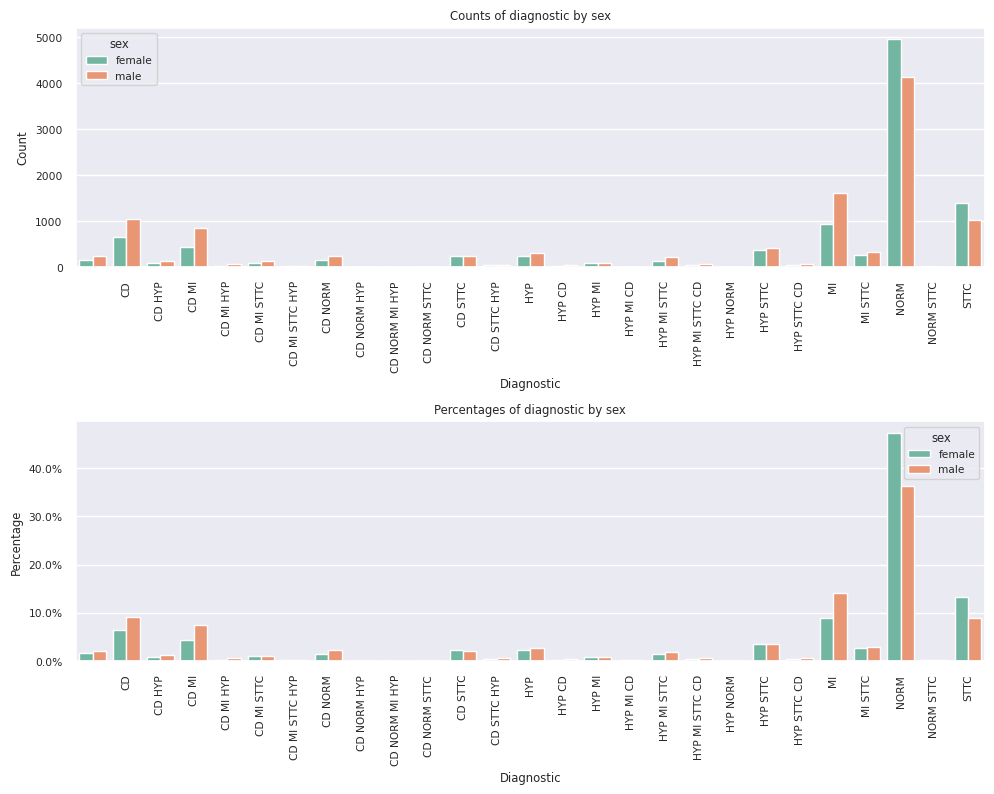

In [35]:
for ds_type in datasets:
    print(f"Dataset type: {ds_type}")
    crplt.plot_distribution_diagnostic_sex(data[ds_type]["annotations"])

The `diagnostic` distribution per `sex` in the different splits is similar.
`female` has more `NORM` diagnostics. That means that the we have less females in the data and they are mostly healthy. One can expect to be harder to detect problems with a model on females. Something to confirm later.

## Data Augmentation: balancing datasets according to class labels

In this multi-label problem, we have observed that the data is well distributed across splits with respect to `diagnostic`, `sex` and `age`.

However, the label `NORM`  is notably dominant, representing approximately 35% of the data in each split, while the next most common label accounts for about 20%.

The challenge now is to explore if data augmentation can improve model performance. Ideally, a more balanced label distribution within the training split should yield better results. However, this theoretical advantage may not always hold true, and the effectiveness can only be determined through training and testing the models.


**Original data splits distributions**

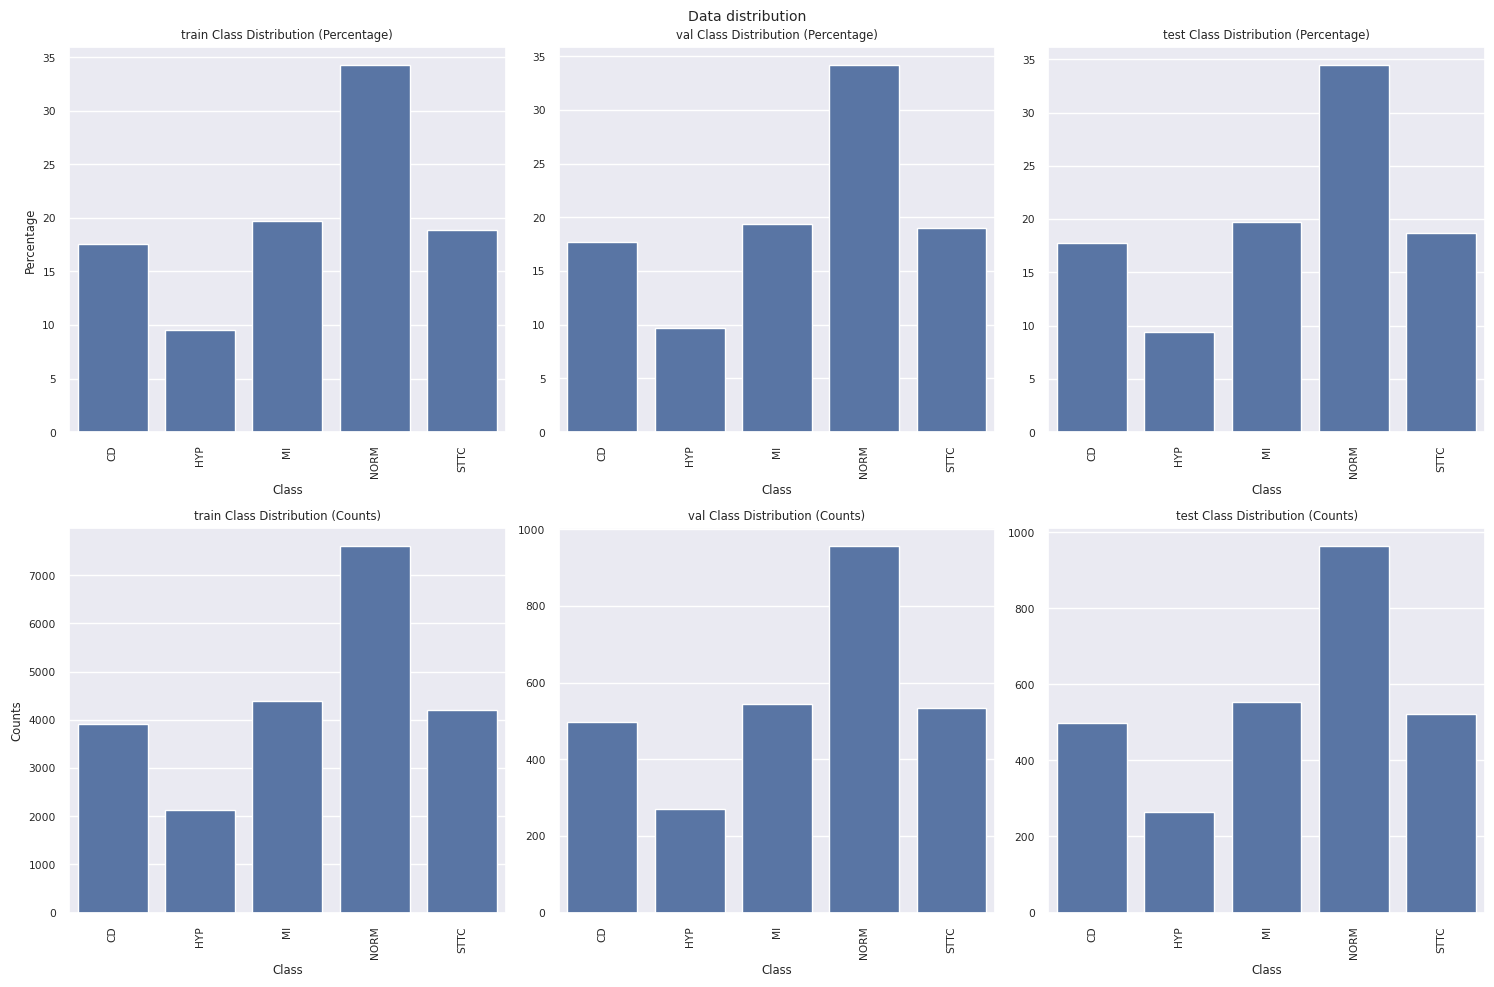

Number of classes: 5
Classes: Counter({'NORM': 7607, 'MI': 4389, 'STTC': 4193, 'CD': 3912, 'HYP': 2121})


In [36]:
# Recap of the original distribution
datasets = ["train", "val", "test"]
class_counts = {}
class_percentages = {}

for dataset in datasets:
    class_counts[dataset], class_percentages[dataset] = calculate_distribution(data[dataset]["labels"],
                                                                                       use_combo=False)
crplt.plot_data_distribution(class_counts, class_percentages)

num_classes = len(class_counts["train"])
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_counts['train']}")

**Balancing the data splits distributions**

The augmentation strategy will focus on cases with a single label. After resampling this data, multi-labeled cases will be added to the dataset.

We will evaluate the following six data distributions:

- Use the data as it is.
- Use only the oversampled/undersampled data with a single label.
- Oversample/undersample the data with a single label and add the multi-labeled cases.
- Use only the multi-labeled cases.

-- Single label only


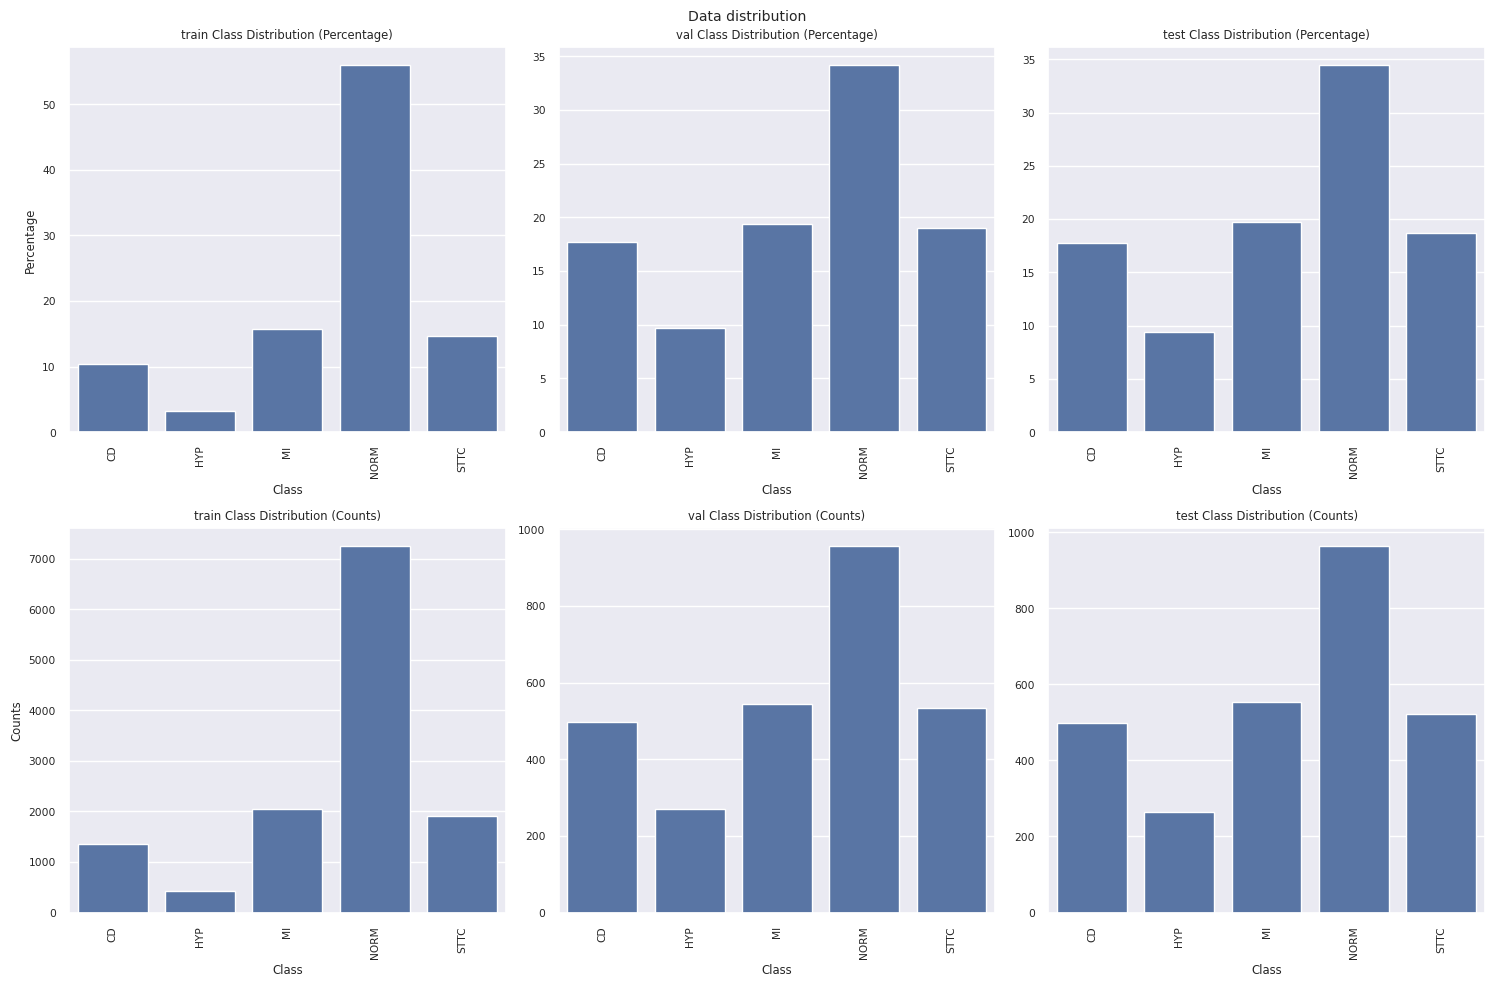

-- Multiple label only


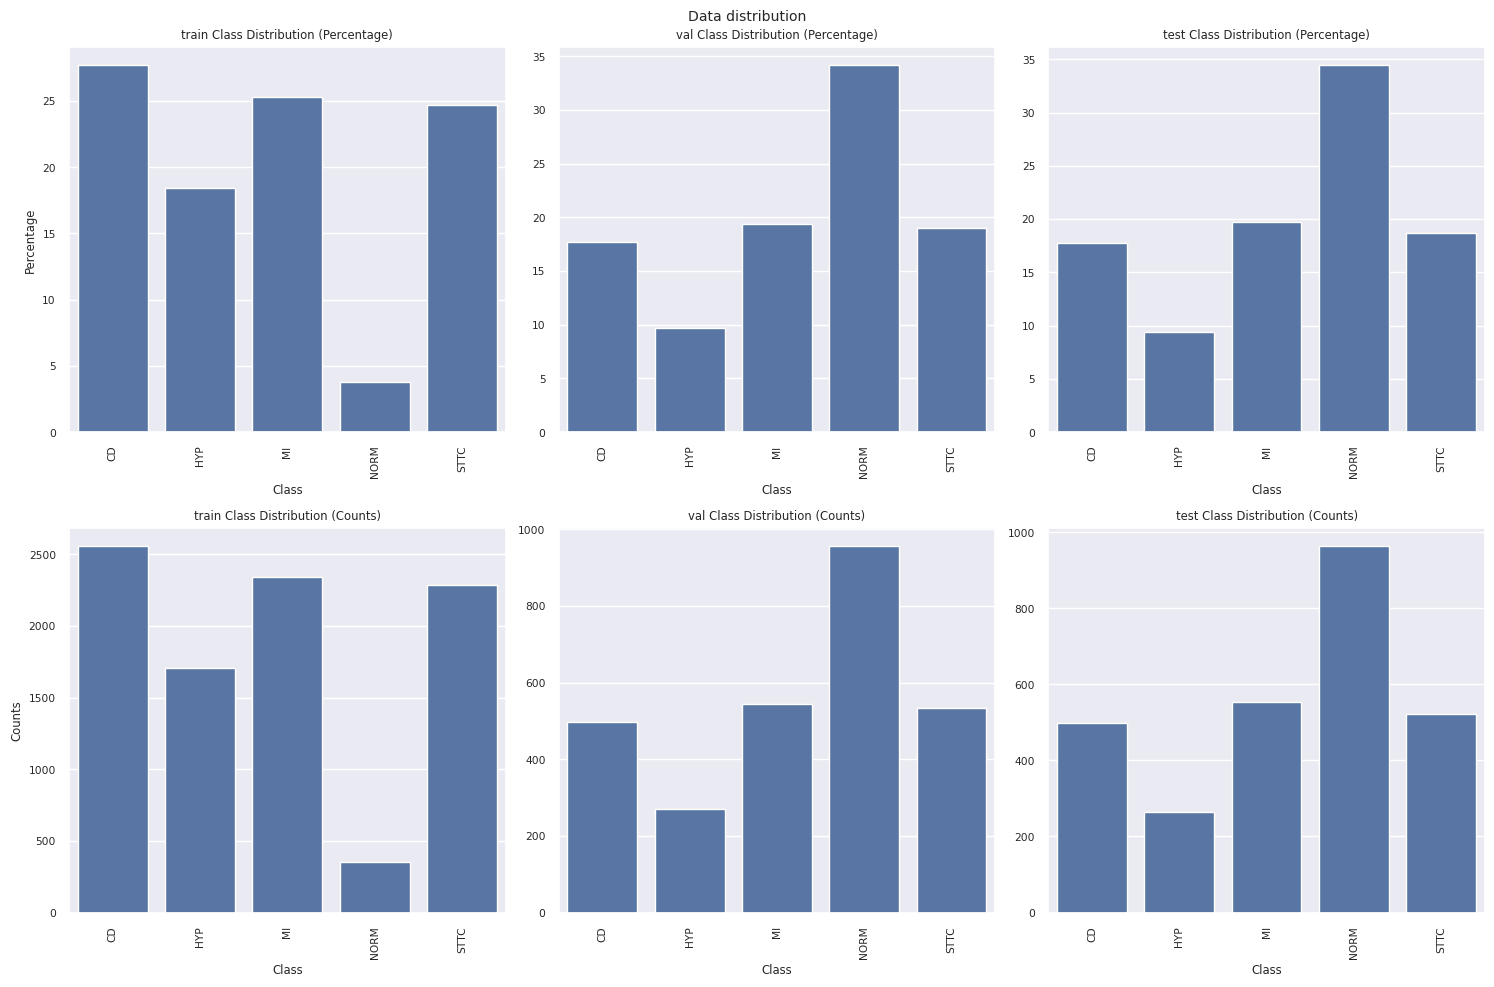

-- Single label under sampled


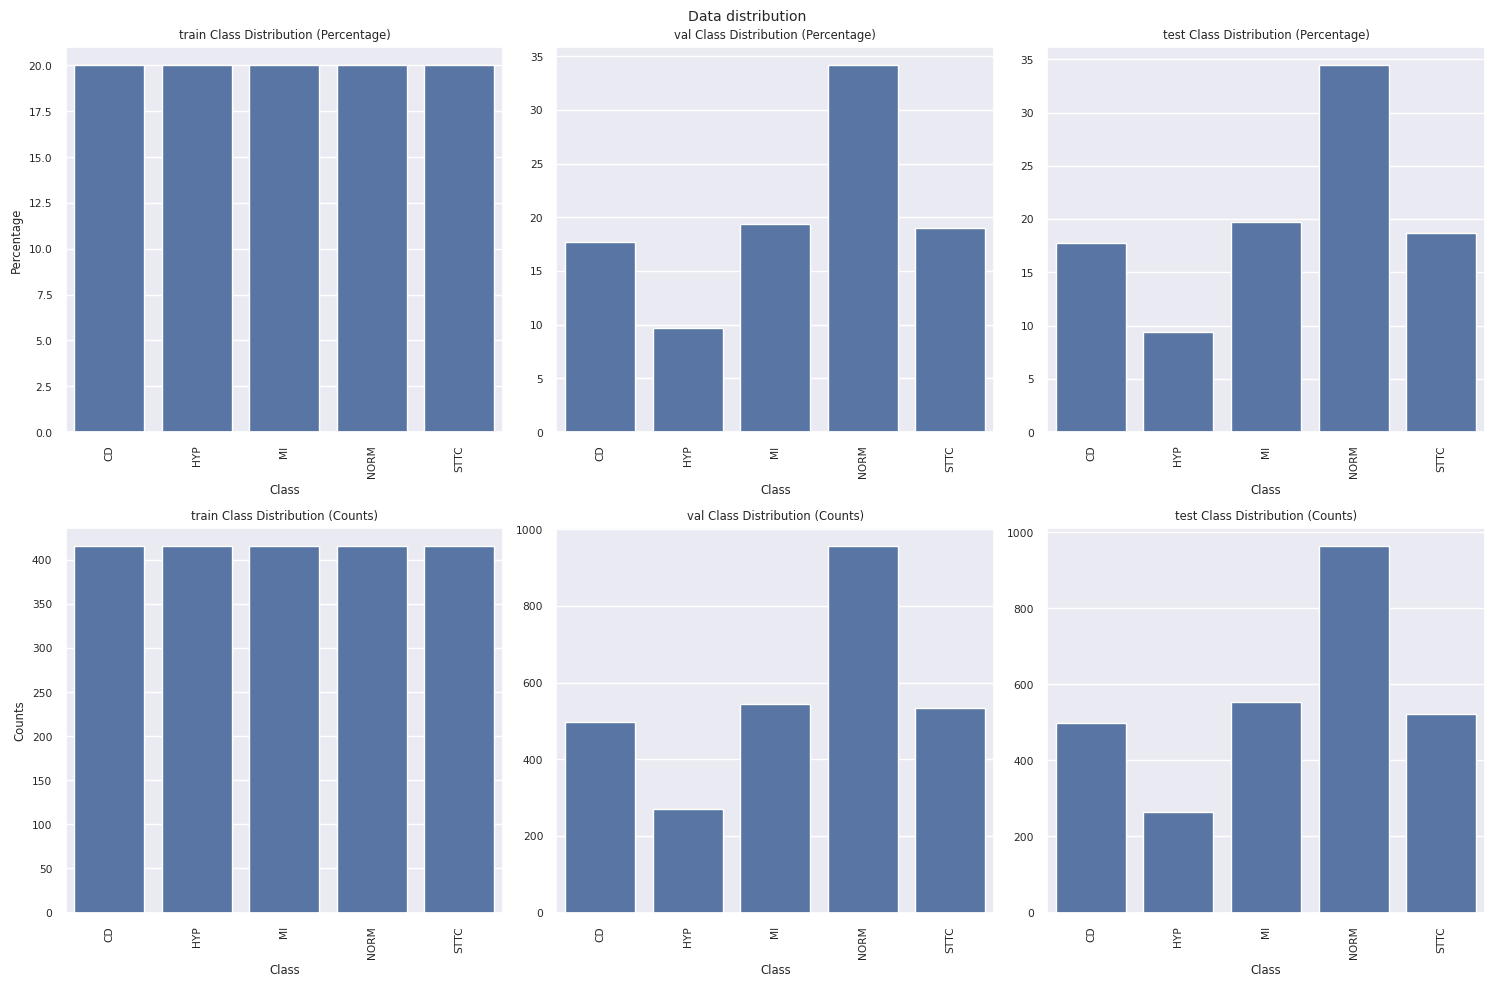

-- Single label under sampled and multi label


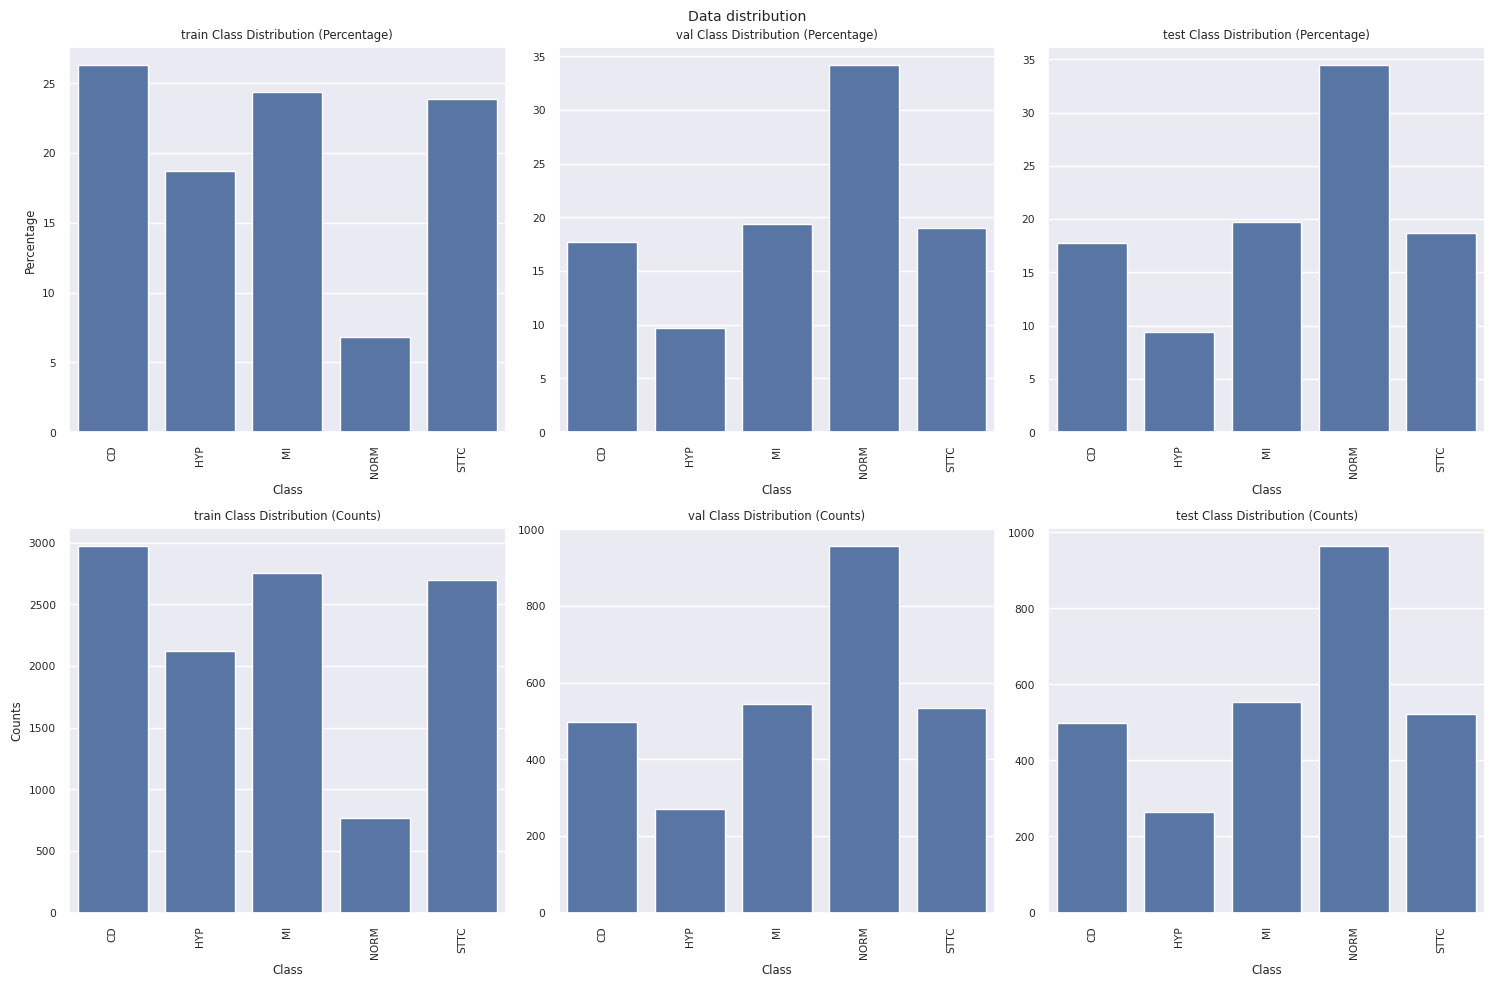

-- Single label over sampled


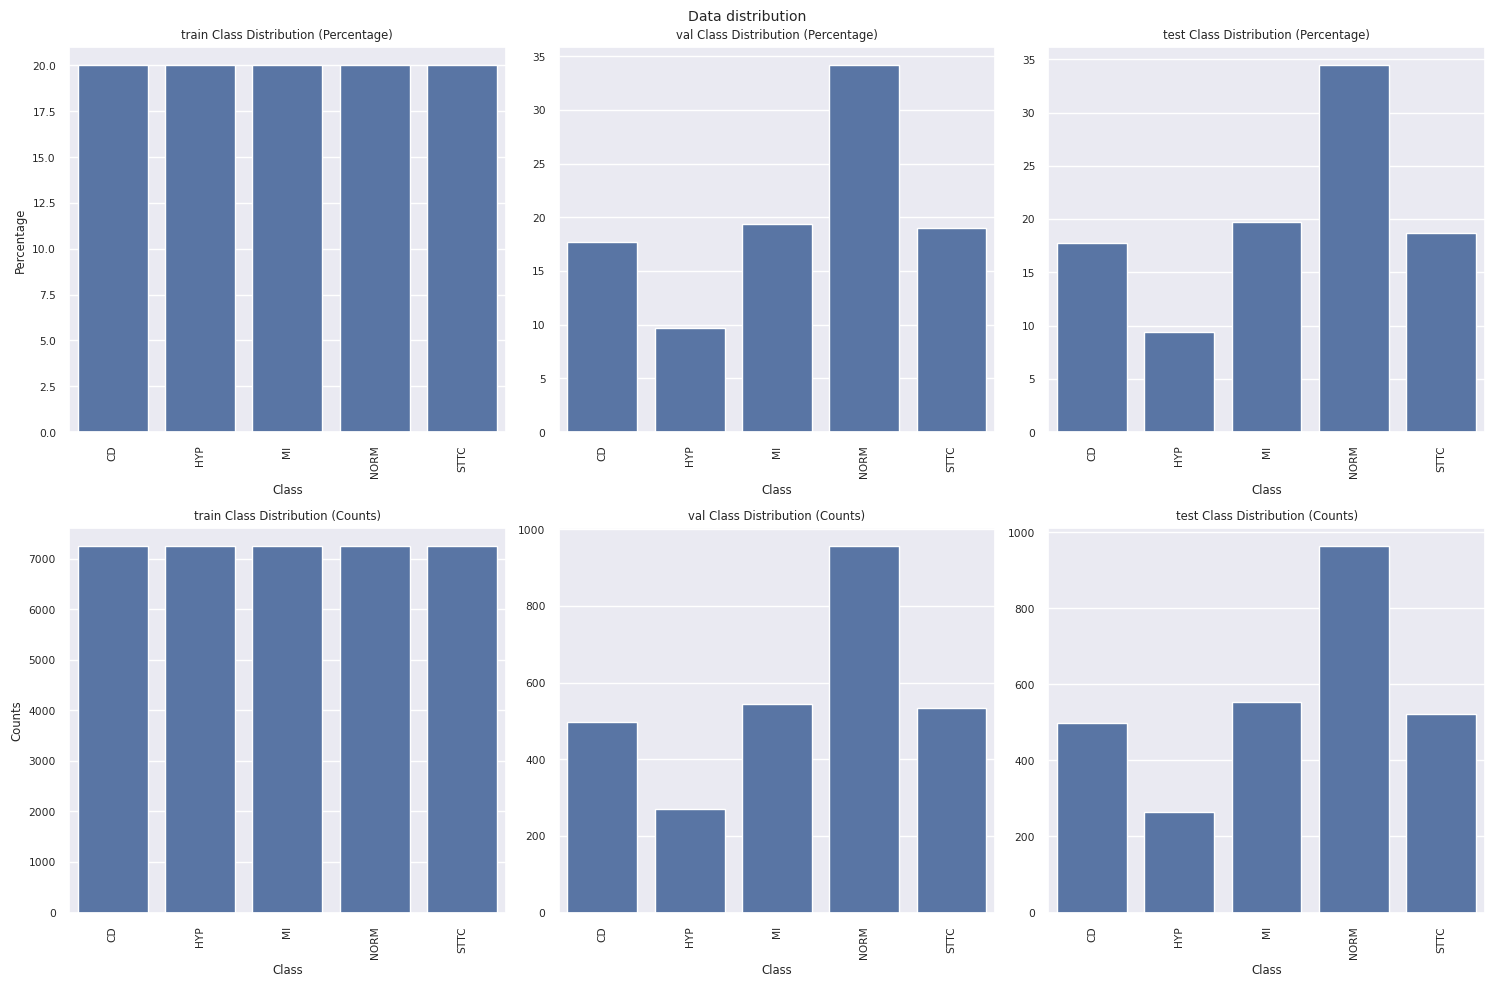

-- Single label over sampled and multi label


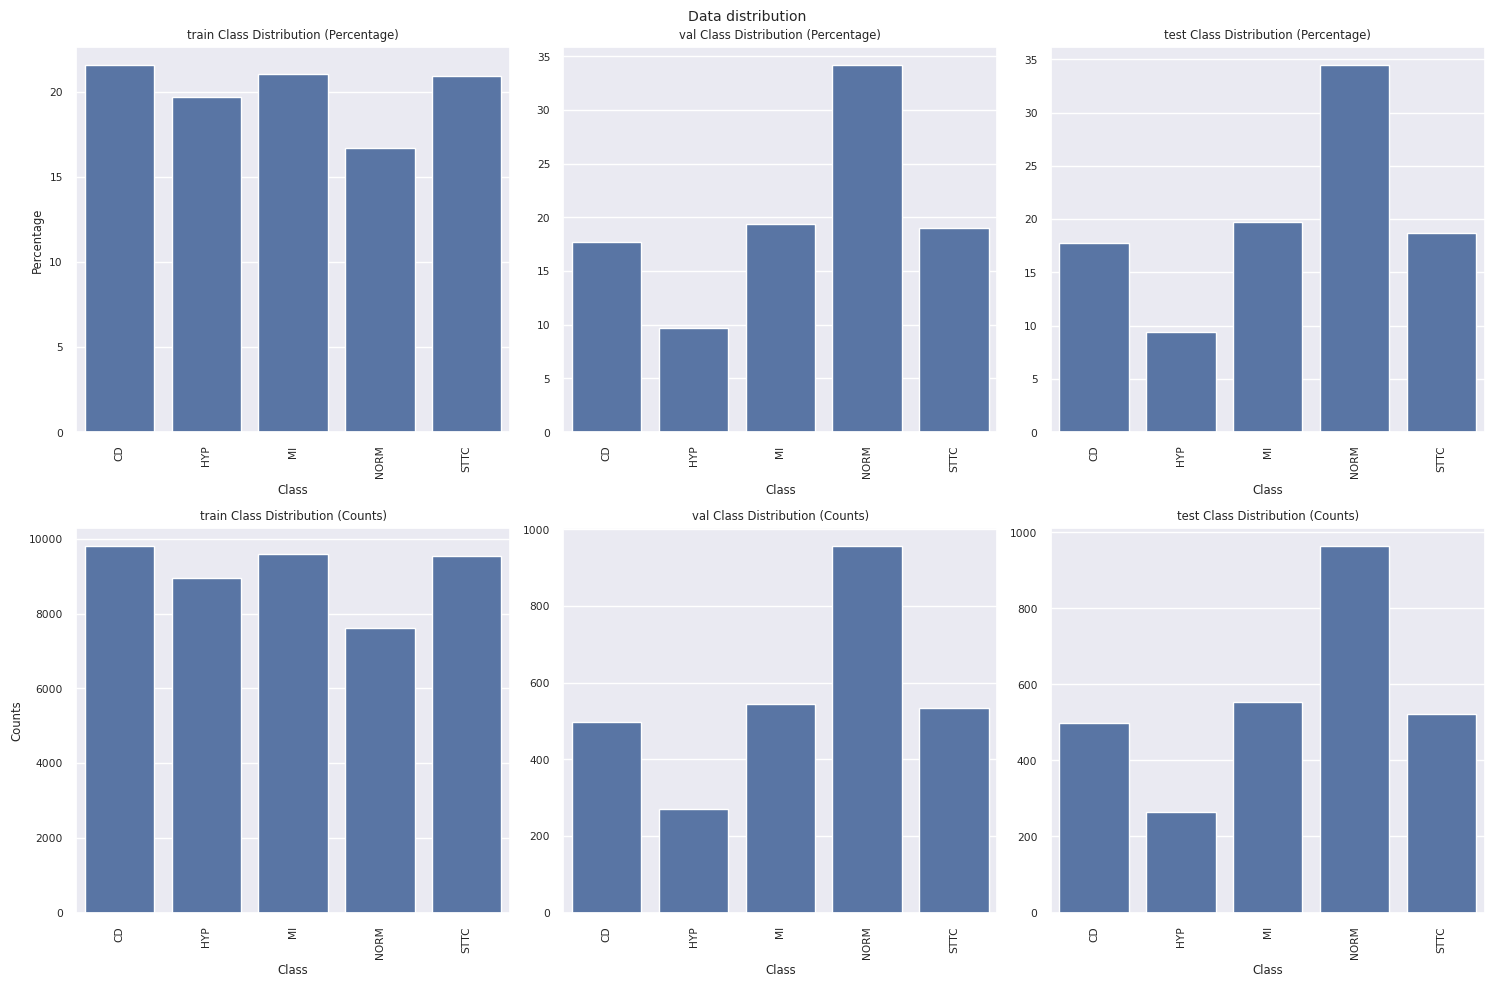

In [37]:
from riotis.core.eda.data_augmentation import DataAugmentor
aug = DataAugmentor()

# Single label only
print('-- Single label only')
new_data, new_labels = aug.get_single_label_only(data["train"]["data"], data["train"]["labels"])
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
crplt.plot_data_distribution(class_counts, class_percentages)

print('-- Multiple label only')
# Multi labels only
new_data, new_labels = aug.get_multi_label_only(data["train"]["data"], data["train"]["labels"])
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
crplt.plot_data_distribution(class_counts, class_percentages)

print('-- Single label under sampled')
# Single label under sampled
new_data, new_labels = aug.get_undersampled(data["train"]["data"], data["train"]["labels"], add_multi=False)
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
crplt.plot_data_distribution(class_counts, class_percentages)

print('-- Single label under sampled and multi label')
# Single label under sampled and multi label
new_data, new_labels = aug.get_undersampled(data["train"]["data"], data["train"]["labels"], add_multi=True)
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
crplt.plot_data_distribution(class_counts, class_percentages)

print('-- Single label over sampled')
# Single label over sampled
new_data, new_labels = aug.get_oversampled(data["train"]["data"], data["train"]["labels"], add_multi=False)
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
crplt.plot_data_distribution(class_counts, class_percentages)

print('-- Single label over sampled and multi label')
# Single label over sampled and multi label
new_data, new_labels = aug.get_oversampled(data["train"]["data"], data["train"]["labels"], add_multi=True)
class_counts["train"], class_percentages["train"] = calculate_distribution(new_labels)
crplt.plot_data_distribution(class_counts, class_percentages)

Here displayed the training distribution of classes among the different configuration that will be use for training.

In [38]:
print('EDA completed')

EDA completed


## ML Classification
